In [2]:
import pandas as pd
import data_processing.import_data as imp
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import progressbar as pb
import plot_functions.format_axis as fmt
from plot_functions.load_palette import load_palette

In [3]:
demog_df = imp.import_demographic_file()

long_data = imp.import_all_longitudinal_files(clean_only=True, add_demog=True)

IMPORTING LONGITUDINAL DATA FROM:
	/Users/akre96/Data/DGC_Study/Longitudinal Data with New Barometric Data
	Only importing patients with demographic information, and data until end of study
	Removed 0 subjects 33 remain
	Filtering for time points newer than June 2016
	Adding Demographic information to longitudinal data


In [4]:
demog_cols = demog_df.columns[1:]
print(demog_cols)

Index(['redcap_event_name', 'presc_cont_group', 'cont_age',
       'redcap_event_name___pbl', 'demog_gender', 'demog_gender_curr',
       'demog_sex_orient', 'demog_maritalstatus', 'demog_race',
       'demog_race_specify',
       ...
       'catmh_anx_category___fa', 'catmh_mania_severity___fa',
       'catmh_mania_category_old___fa', 'catmh_mania_category___fa',
       'catmh_ss_diagnosis___fa', 'catmh_ss_severity___fa',
       'catmh_ss_category___fa', 'redcap_event_name___ss',
       'final_subject_status', 'final_data_status'],
      dtype='object', length=170)


In [5]:
long_data['catmh_mdd_diagnosis']

0       1
1       1
2       1
3       1
4       1
       ..
3129    1
3130    1
3131    1
3132    1
3133    1
Name: catmh_mdd_diagnosis, Length: 3134, dtype: int64

100% (399 of 399) |######################| Elapsed Time: 0:00:35 Time:  0:00:35


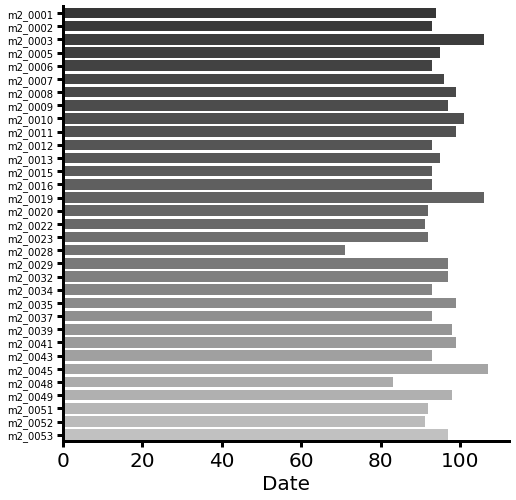

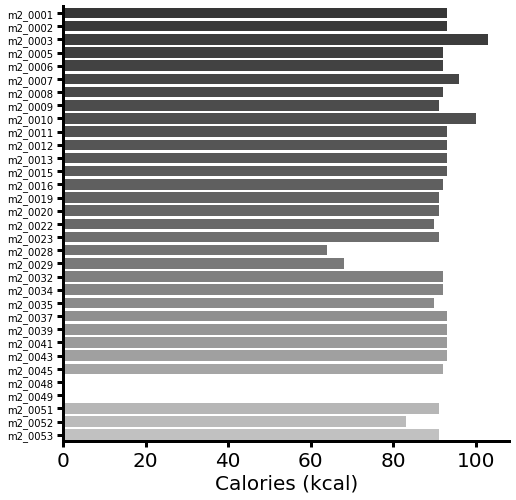

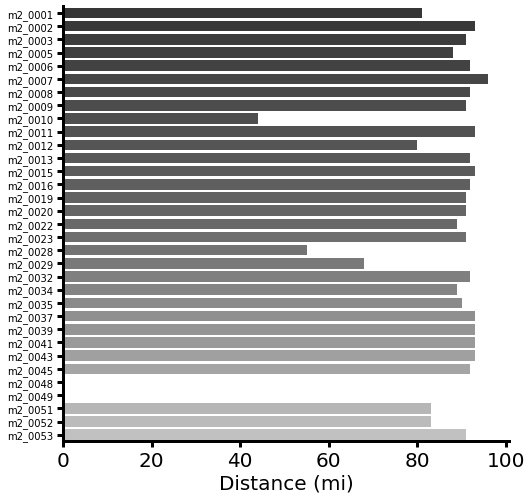

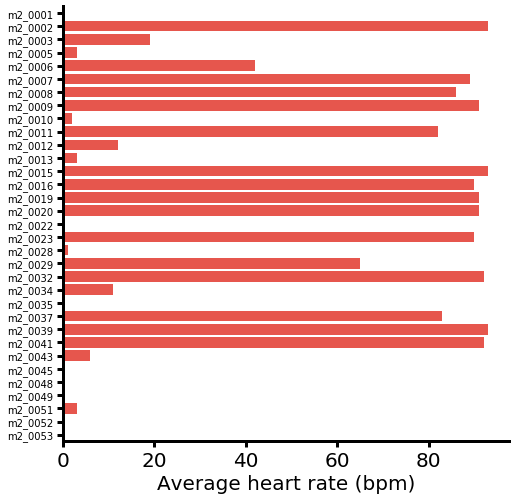

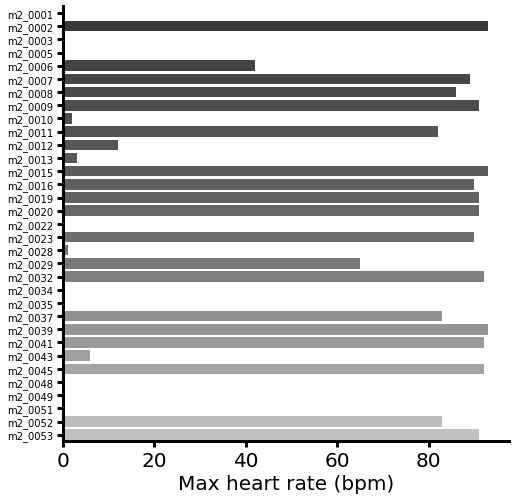

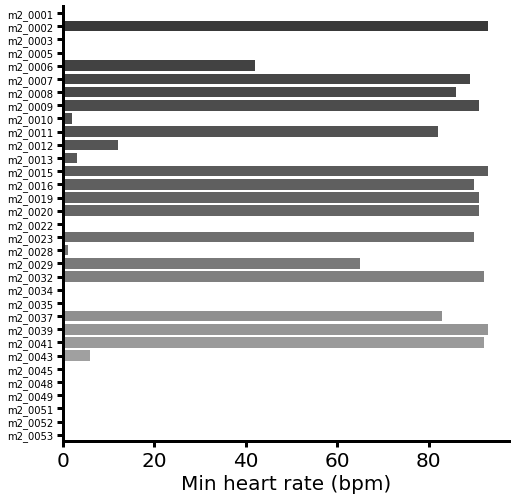

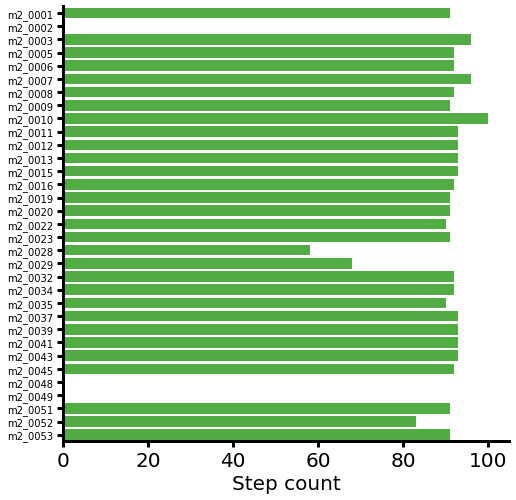

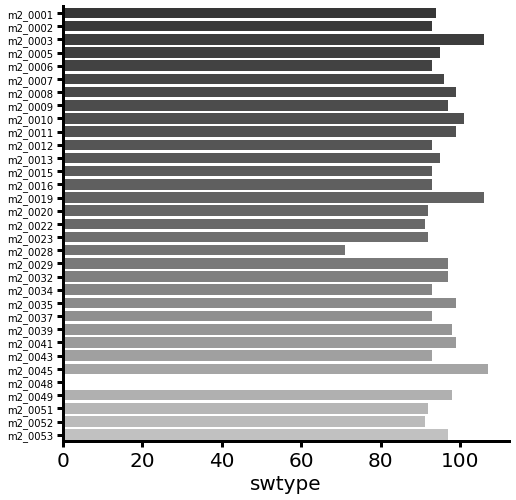

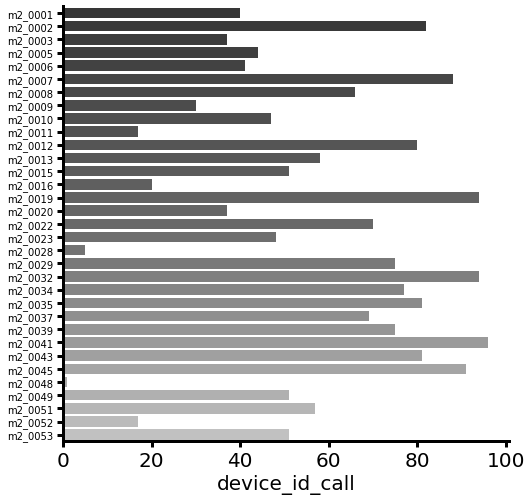

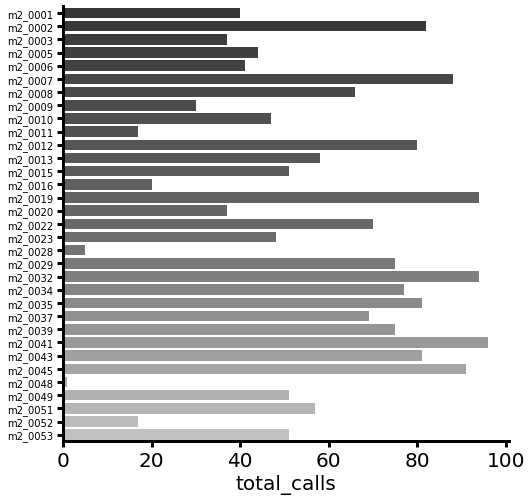

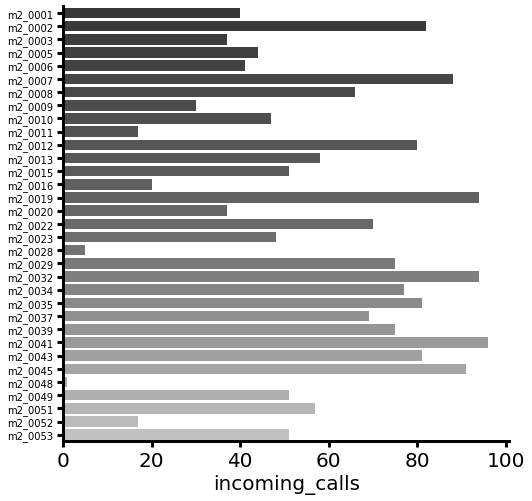

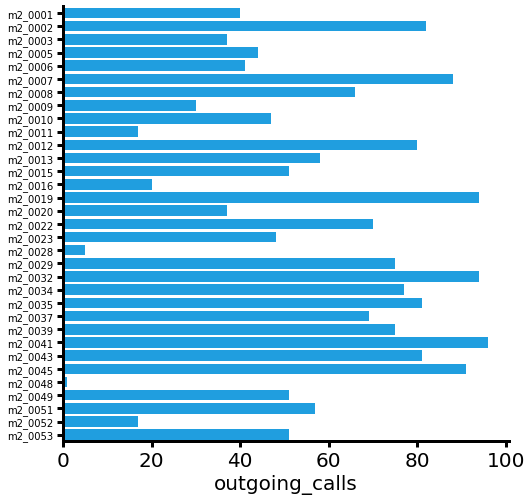

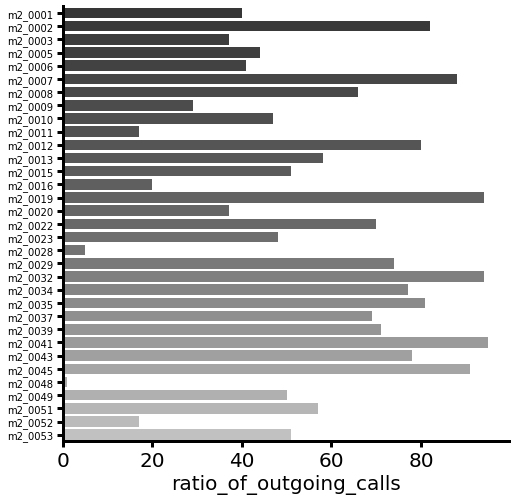

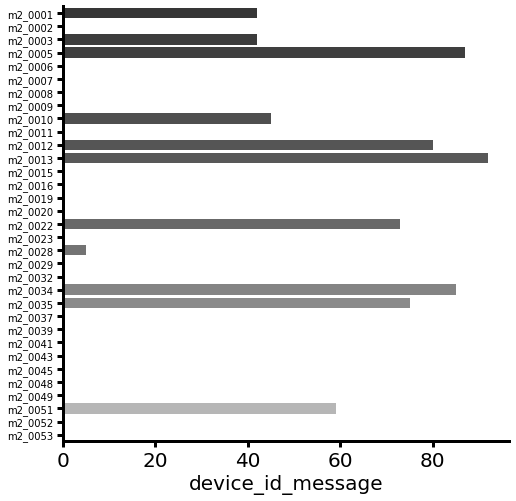

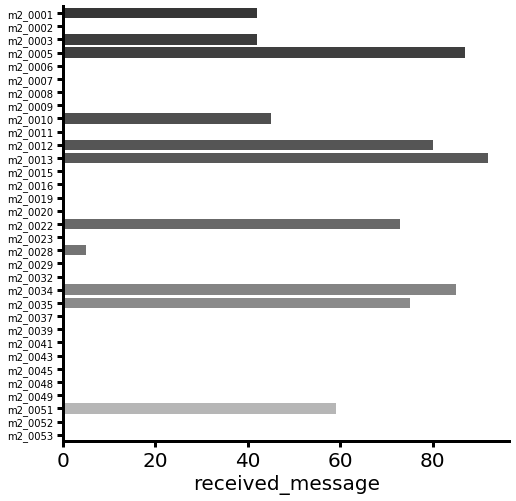

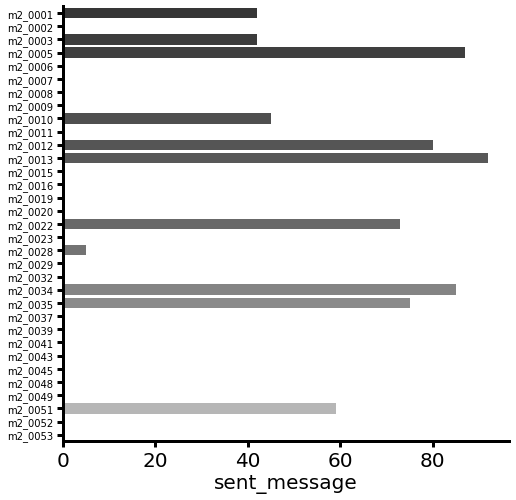

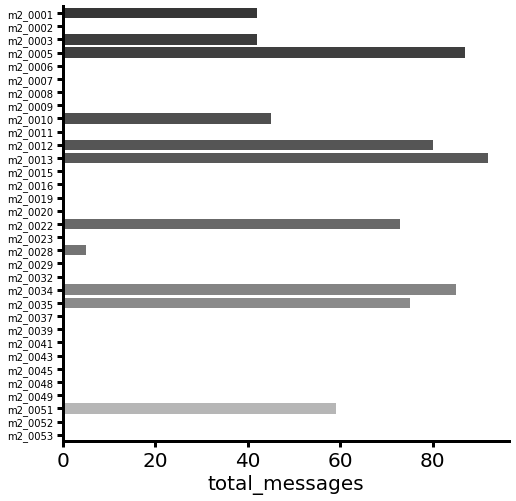

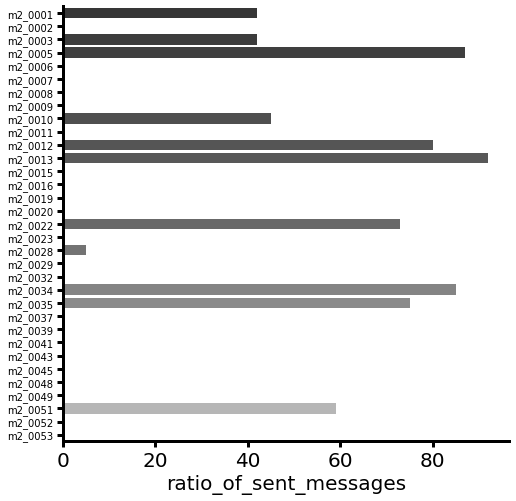

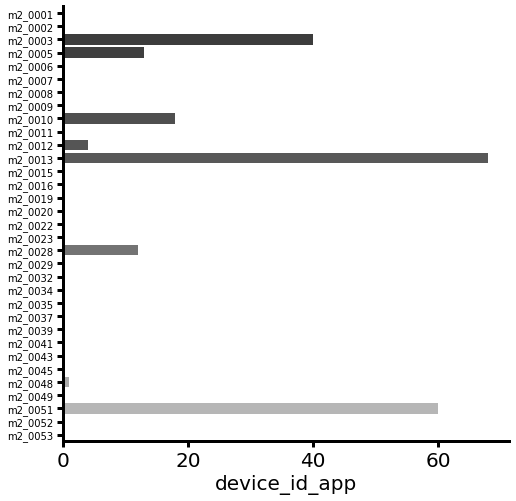

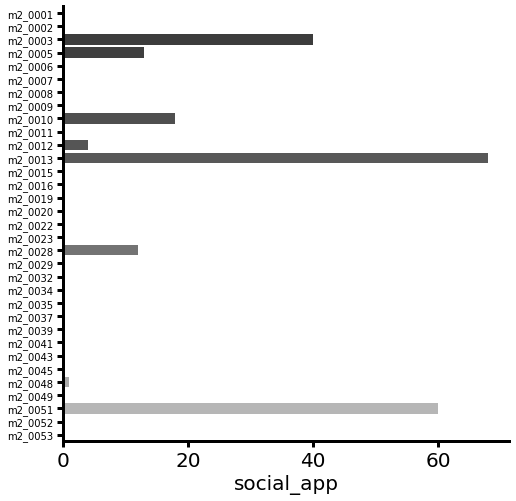

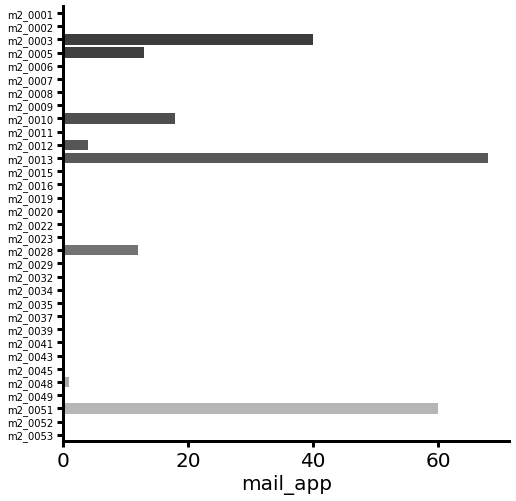

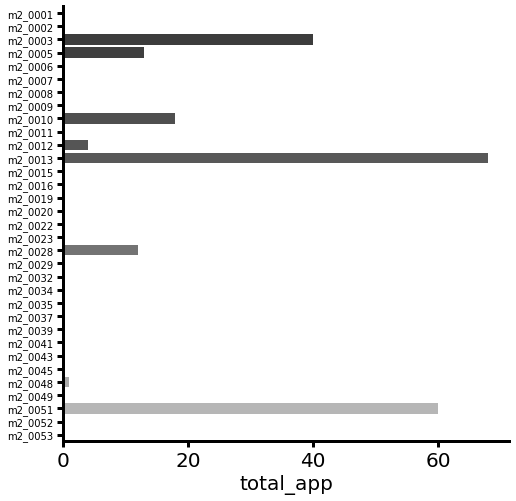

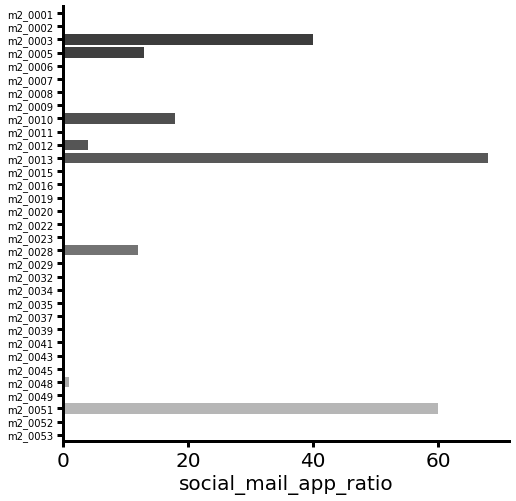

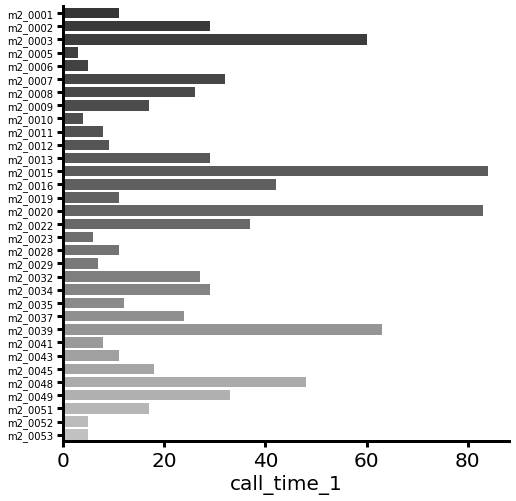

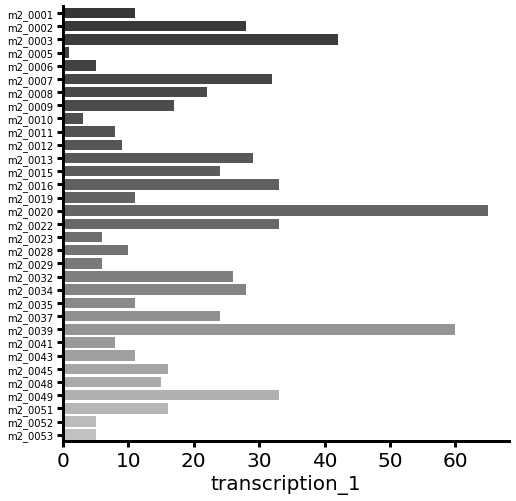

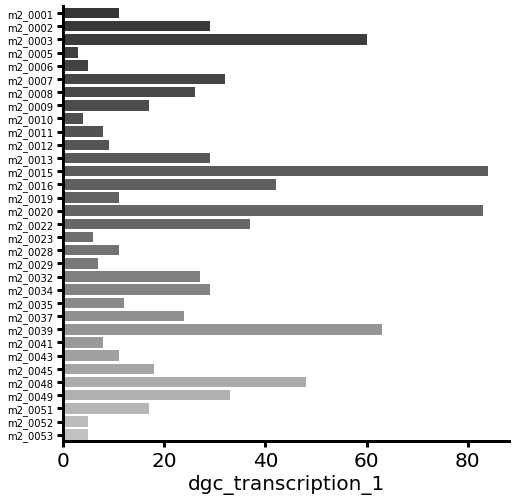

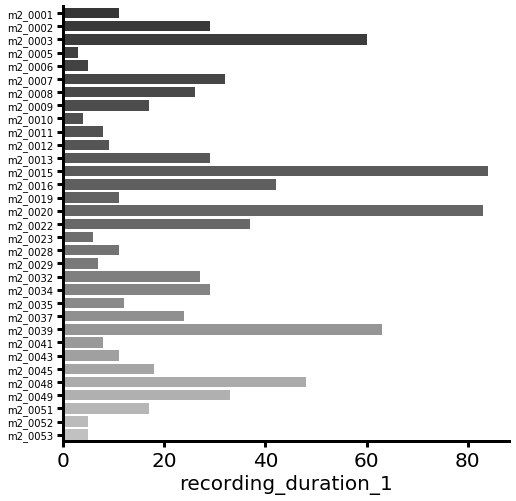

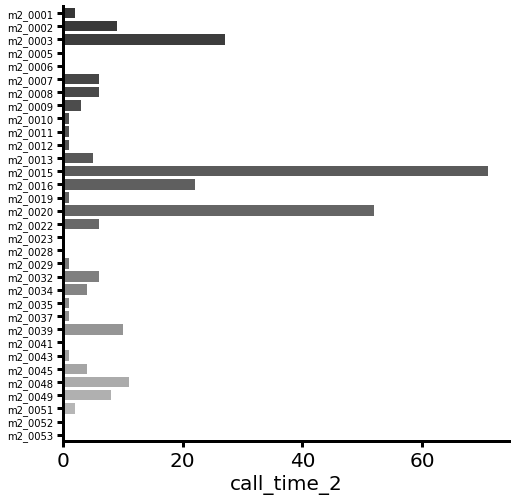

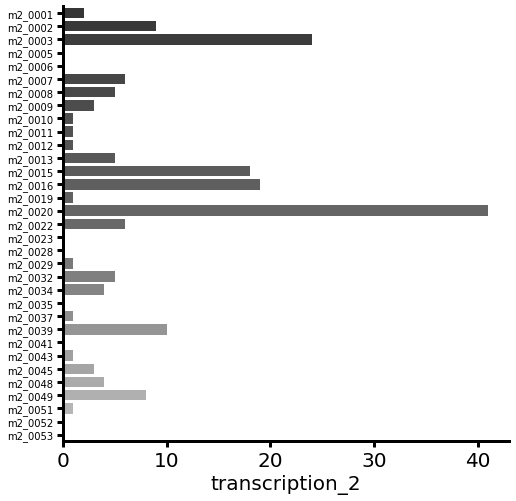

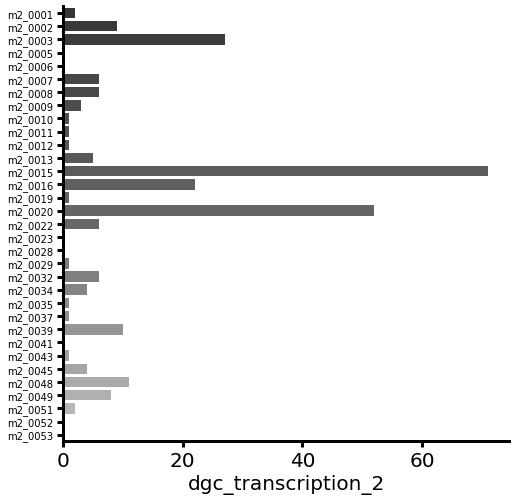

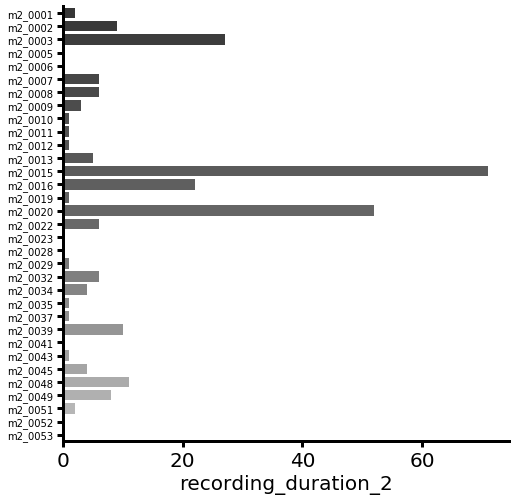

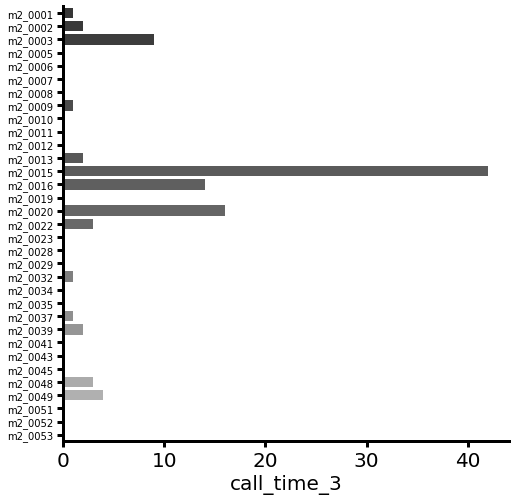

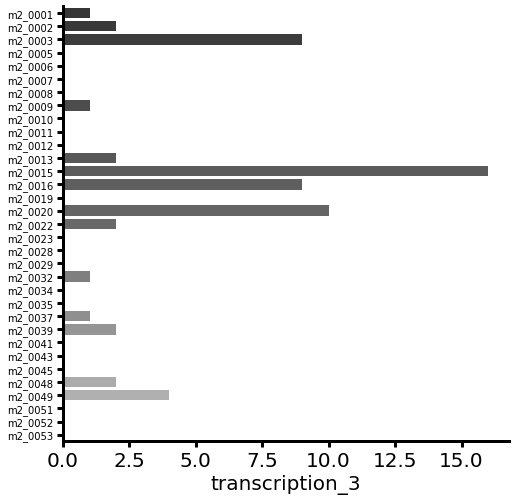

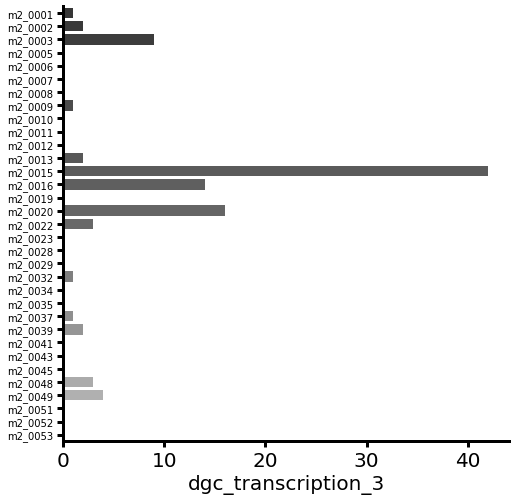

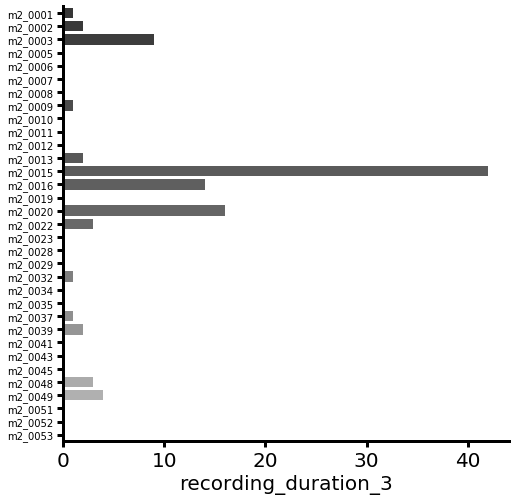

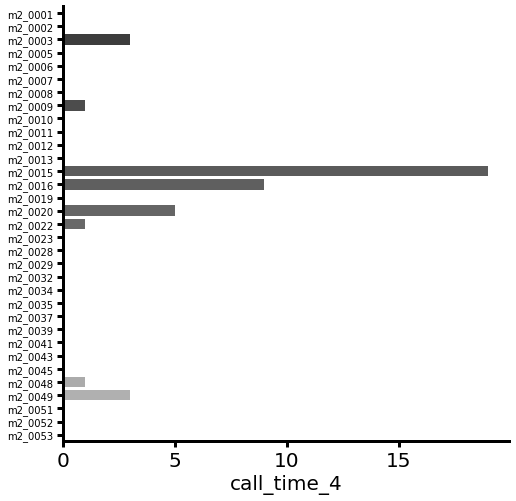

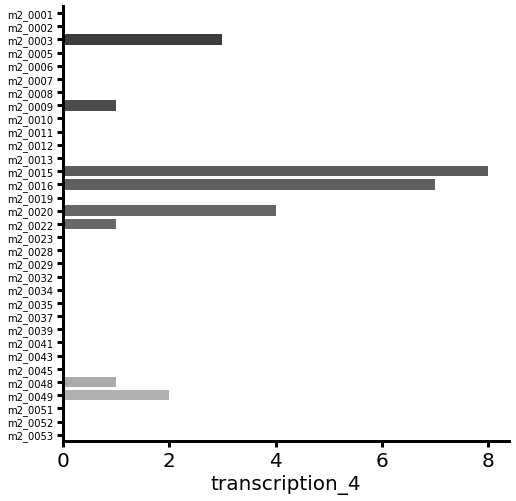

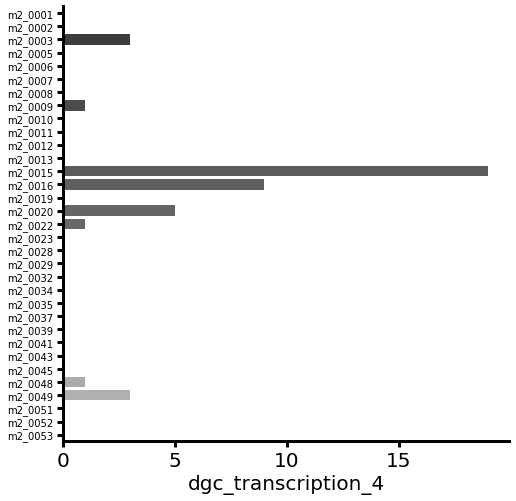

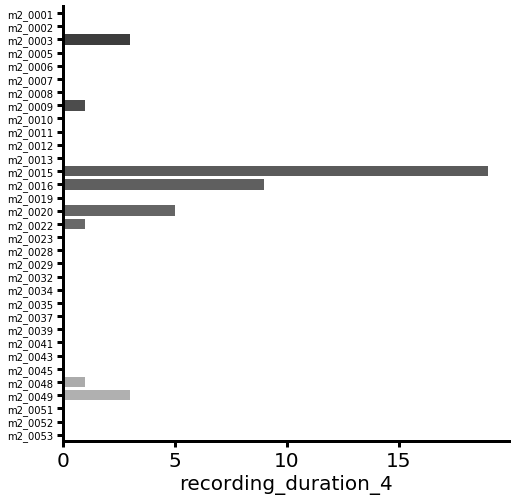

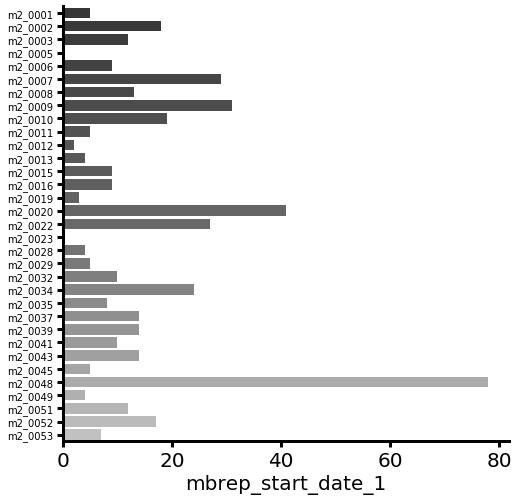

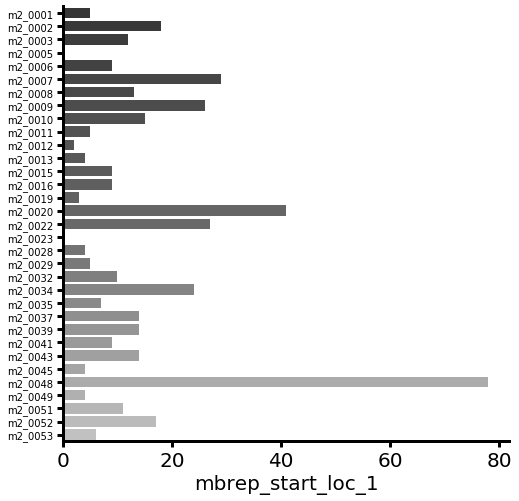

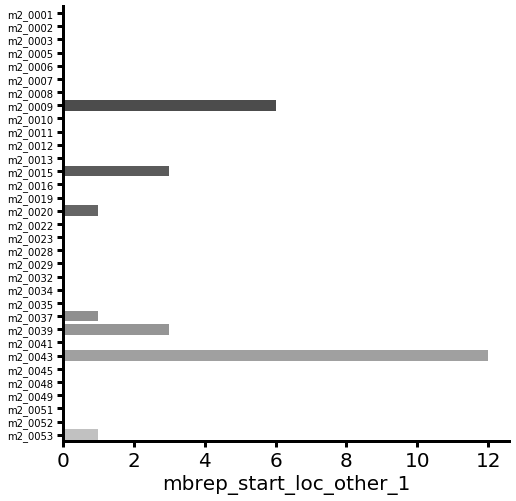

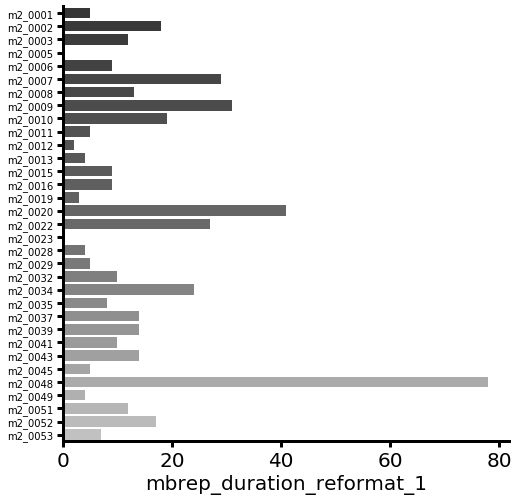

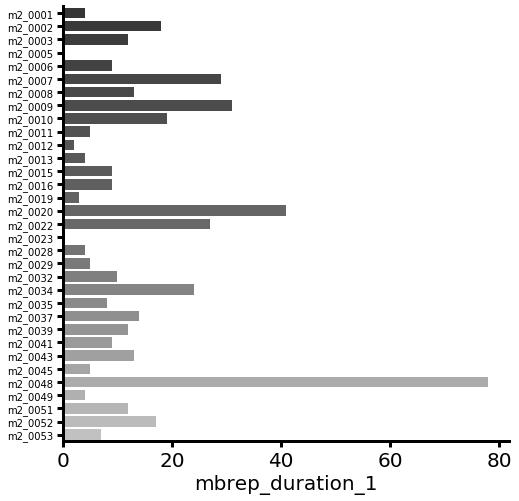

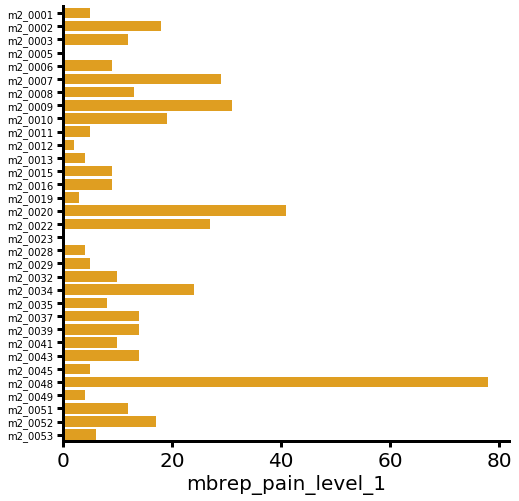

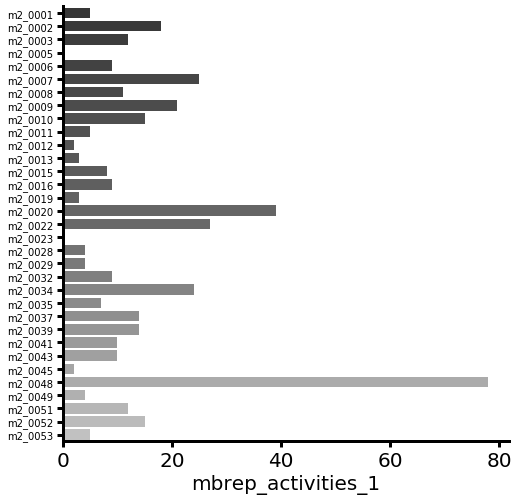

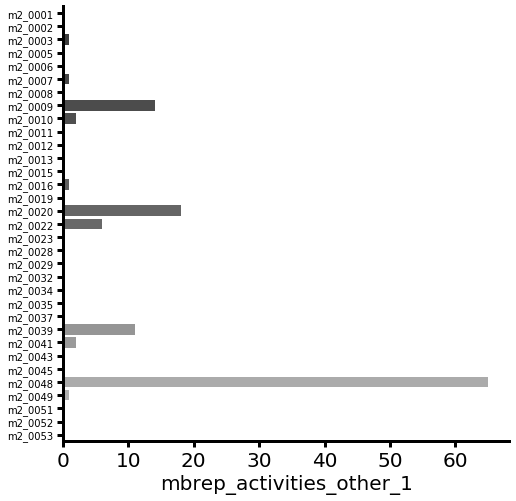

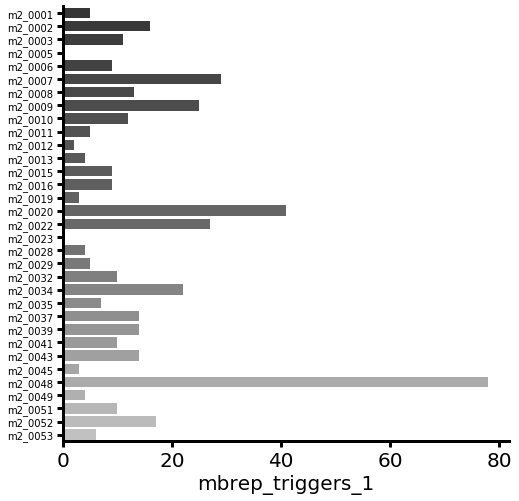

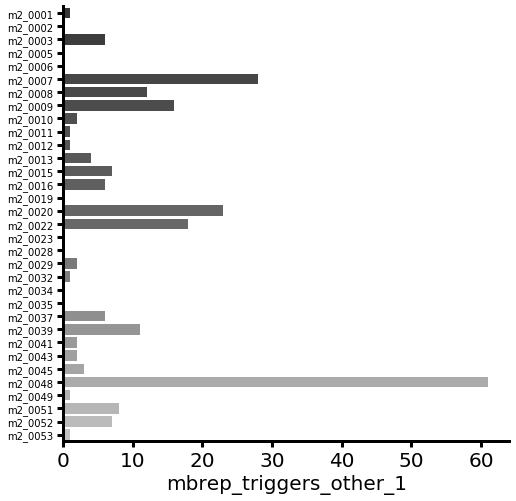

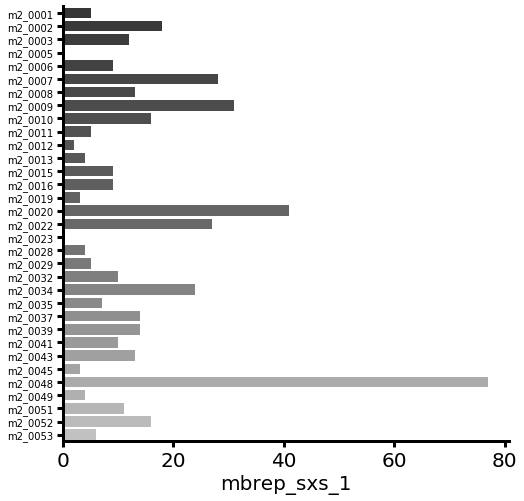

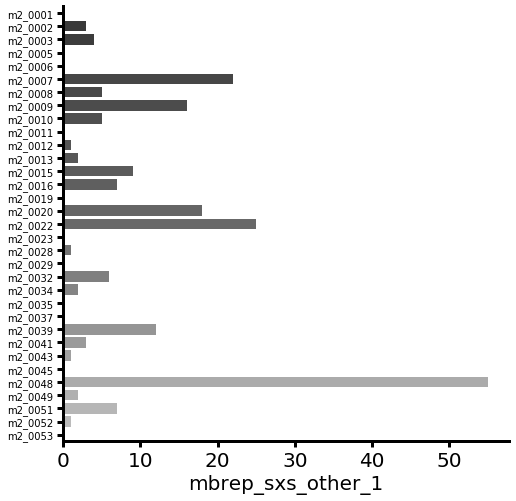

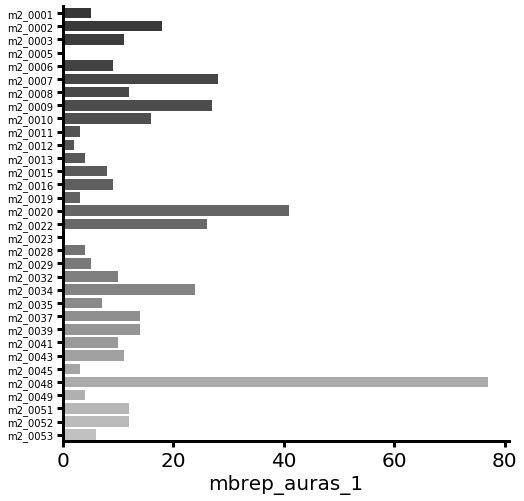

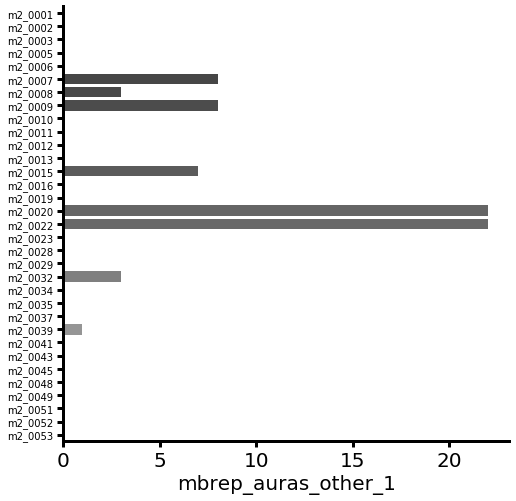

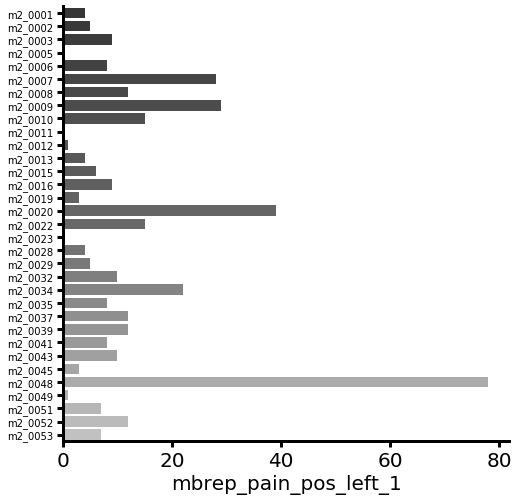

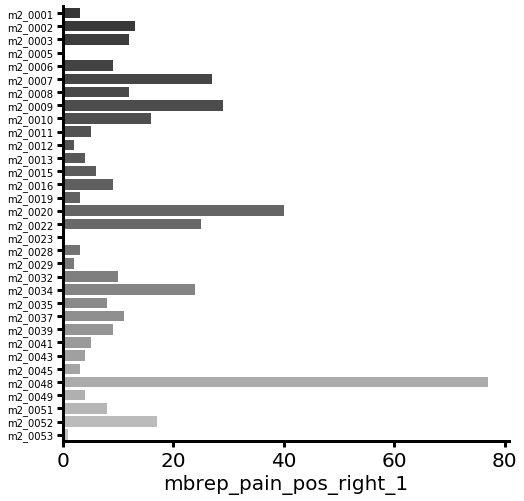

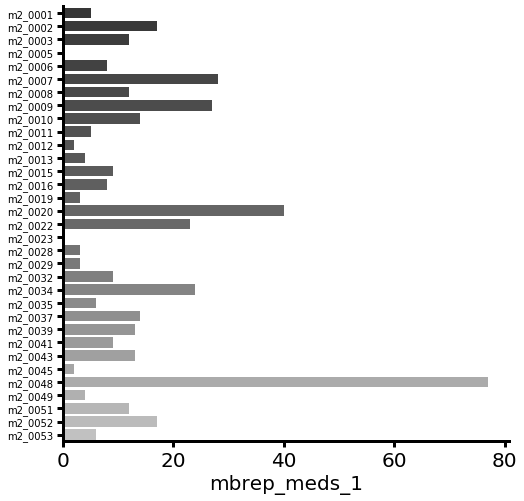

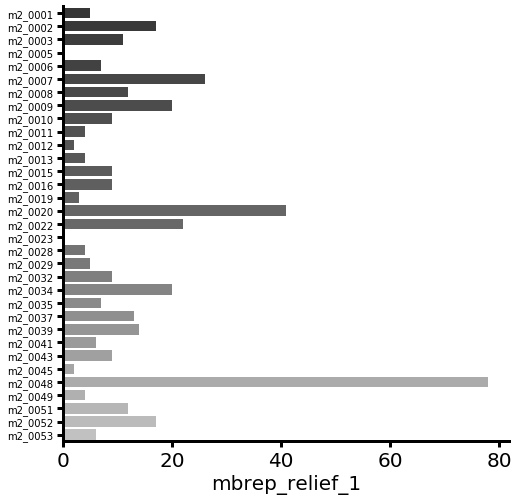

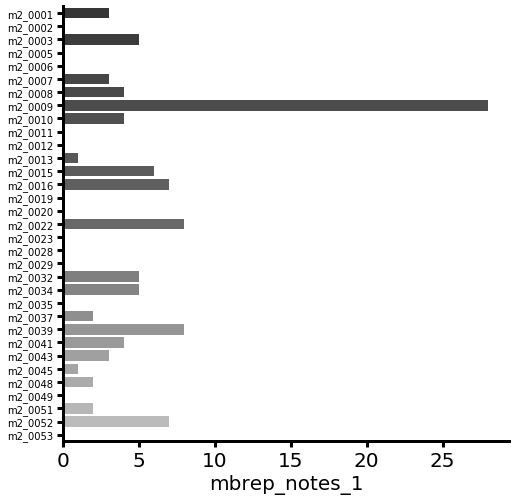

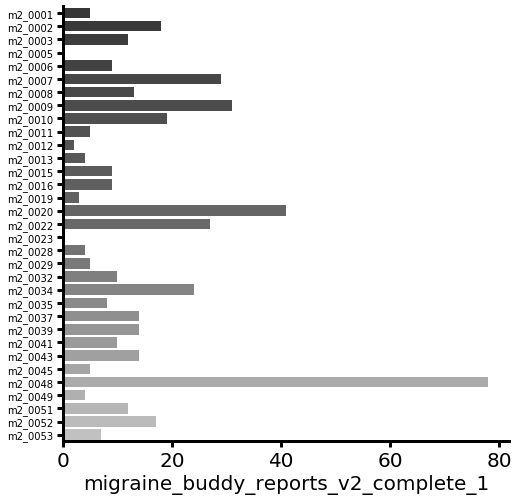

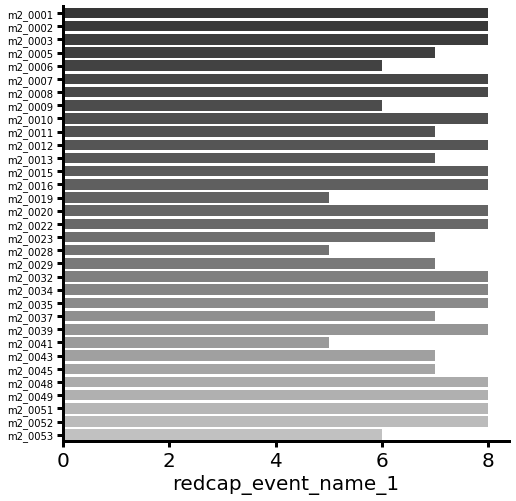

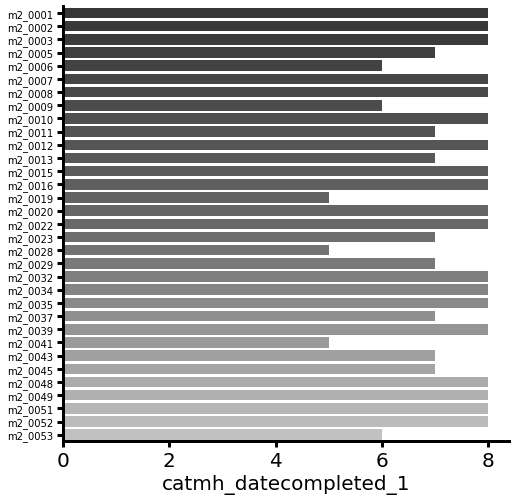

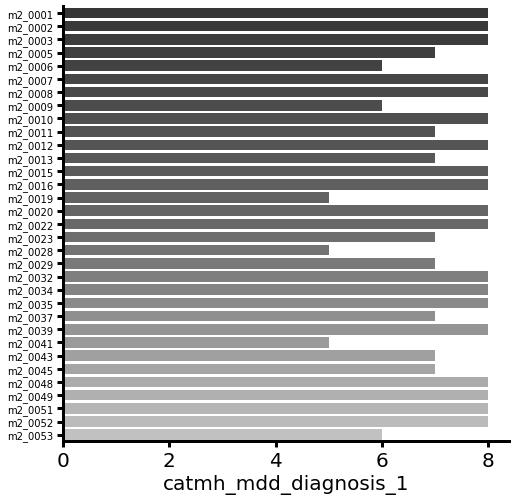

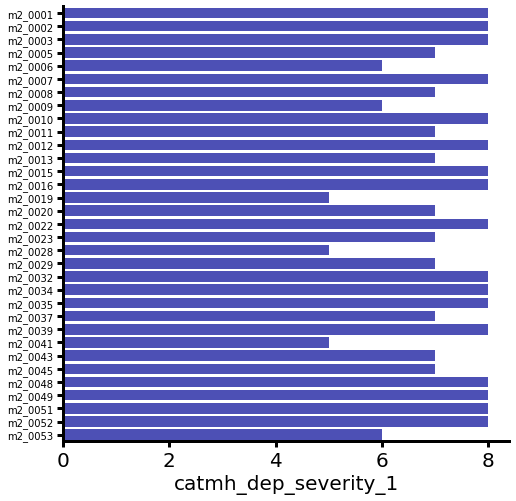

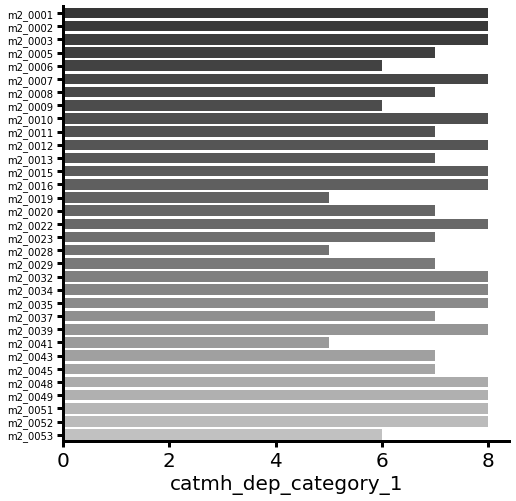

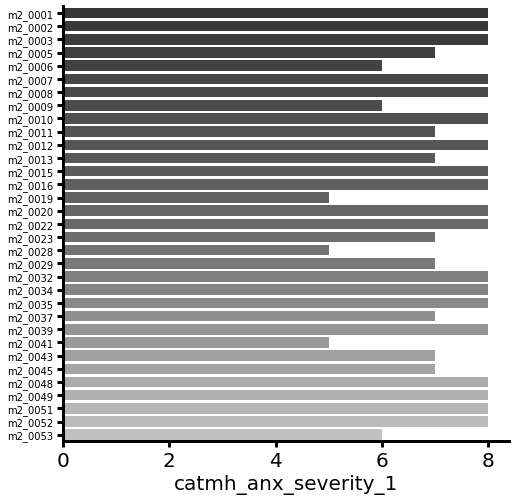

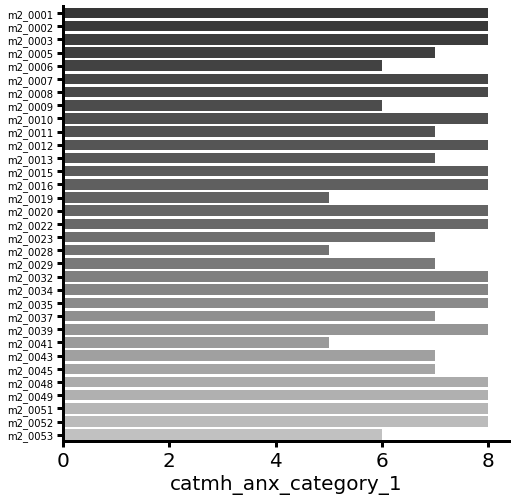

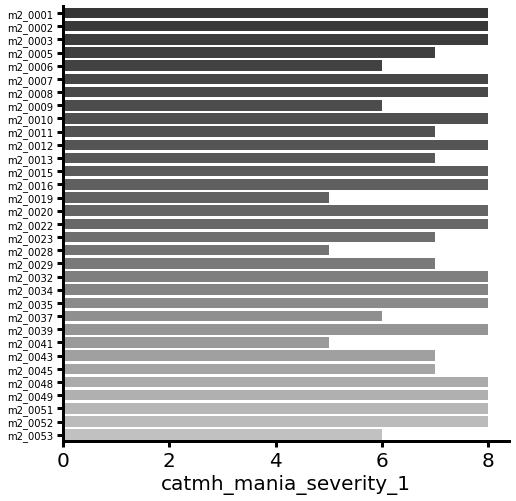

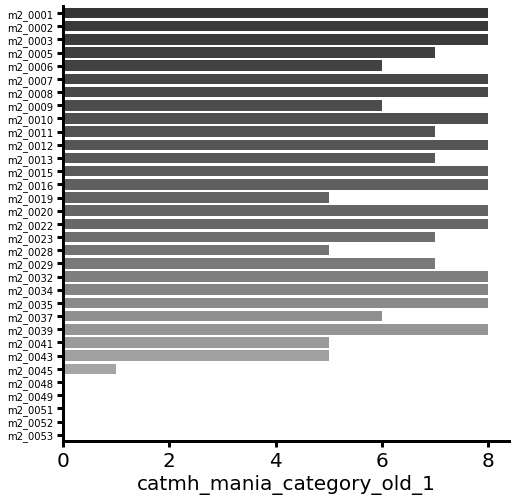

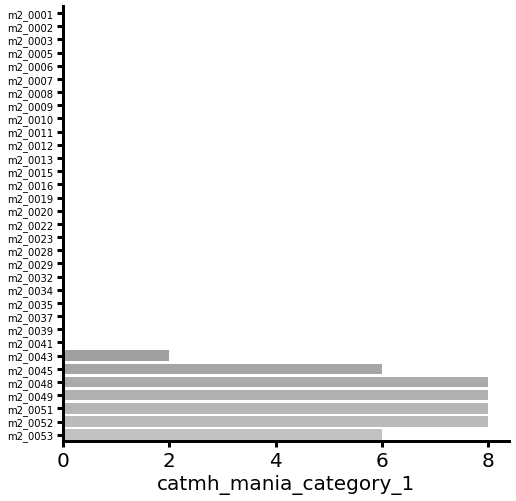

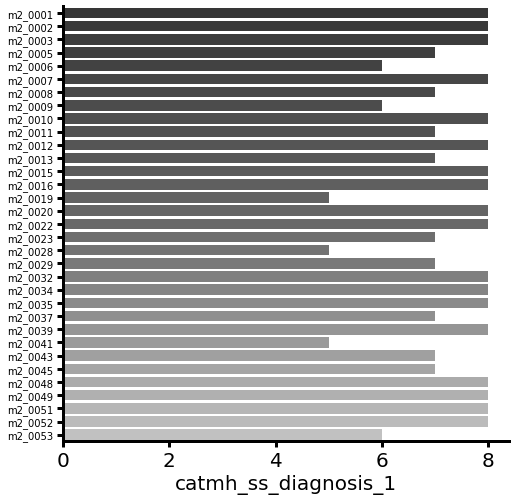

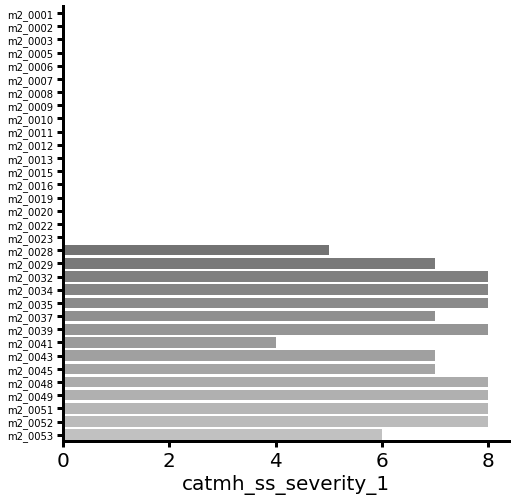

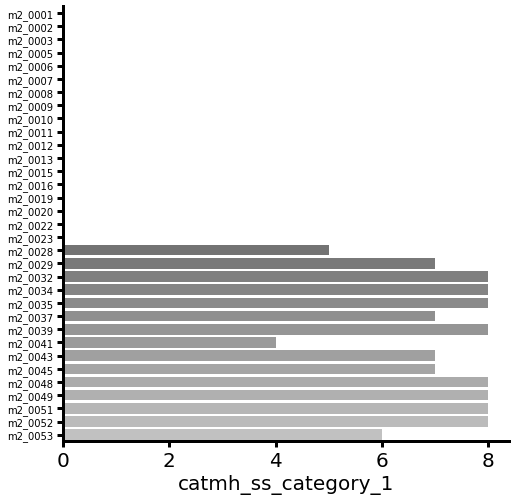

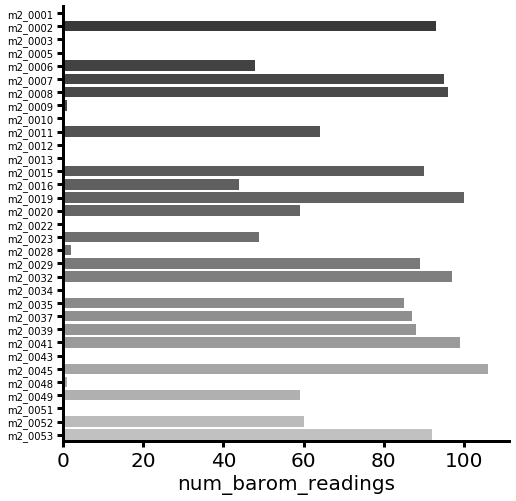

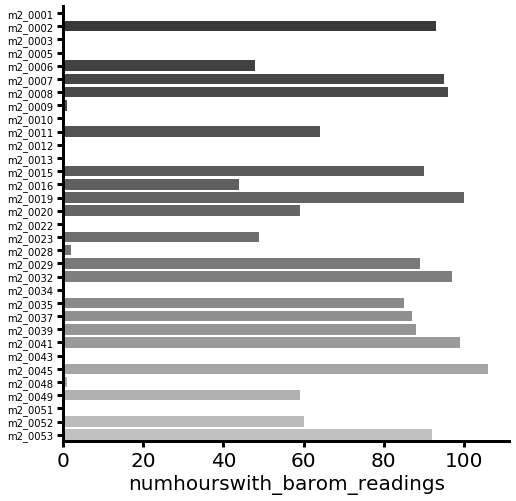

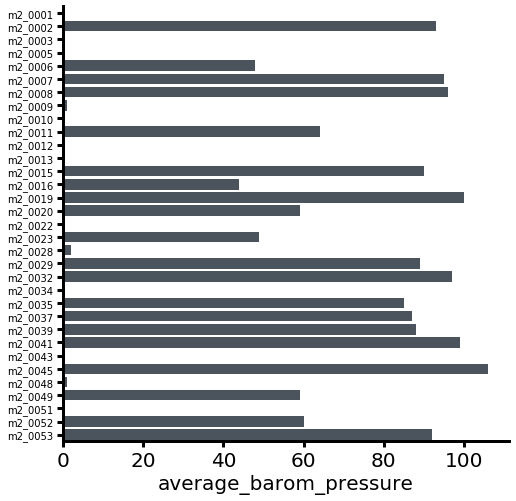

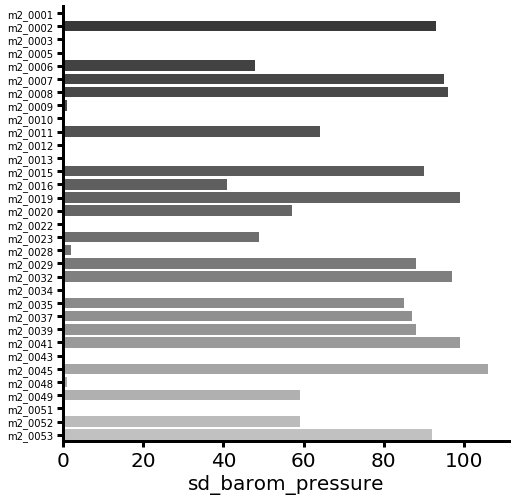

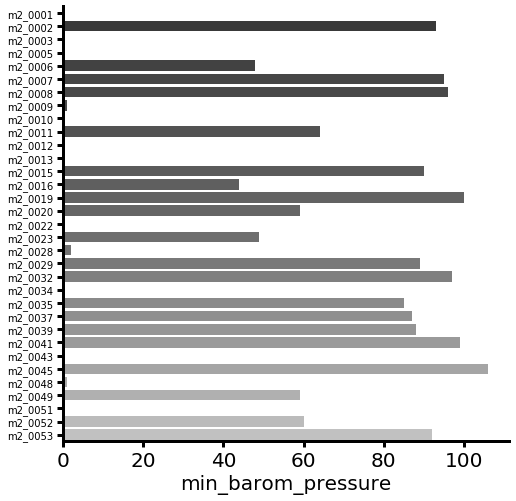

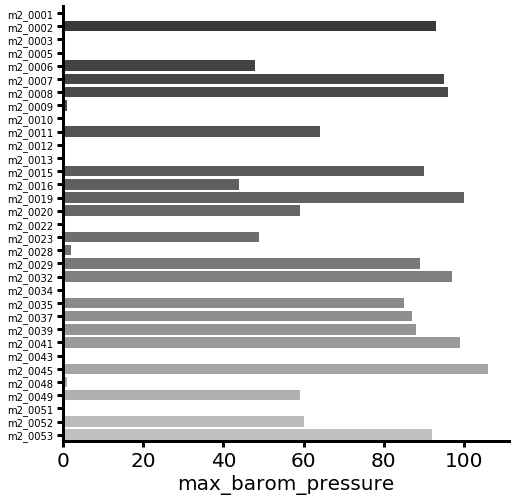

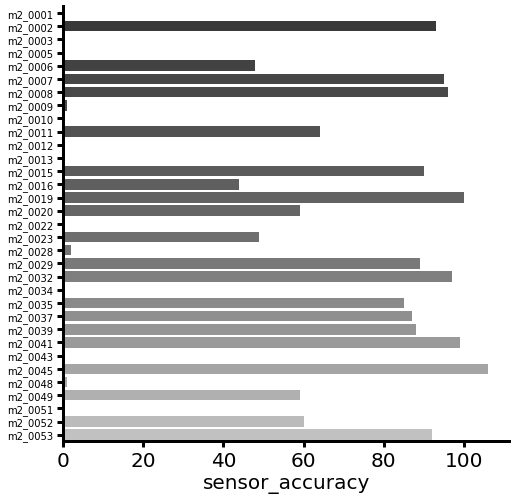

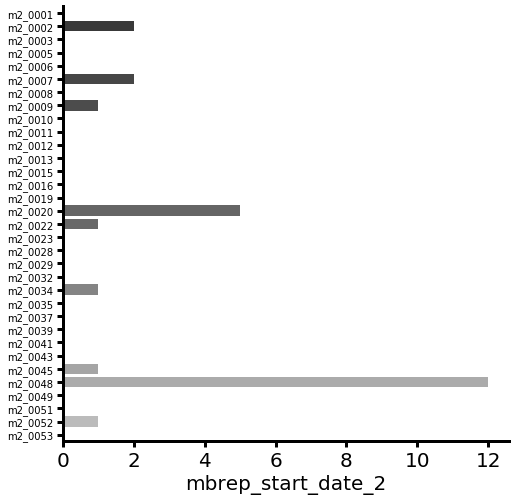

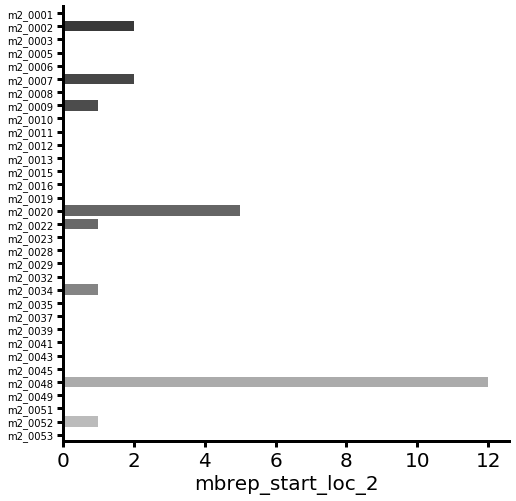

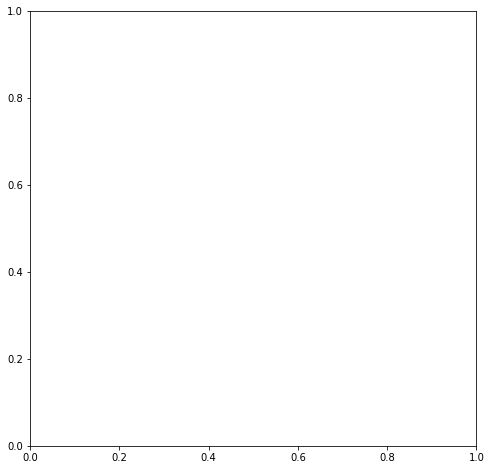

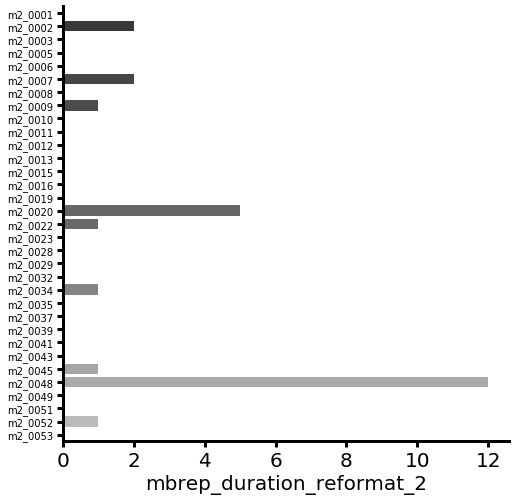

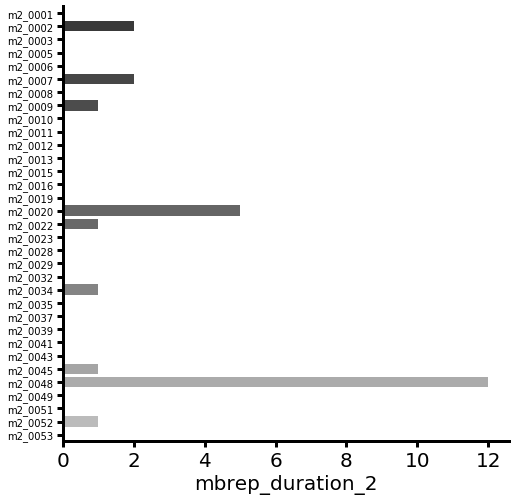

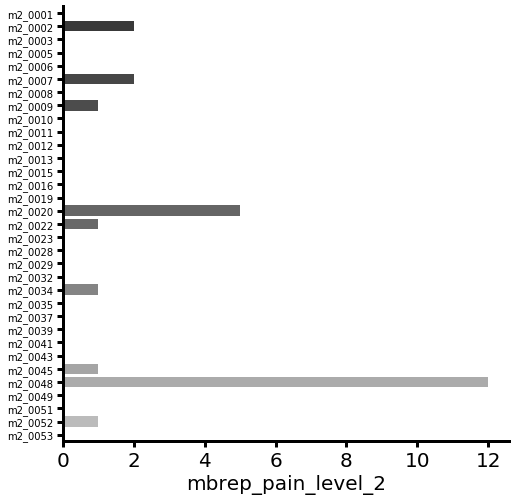

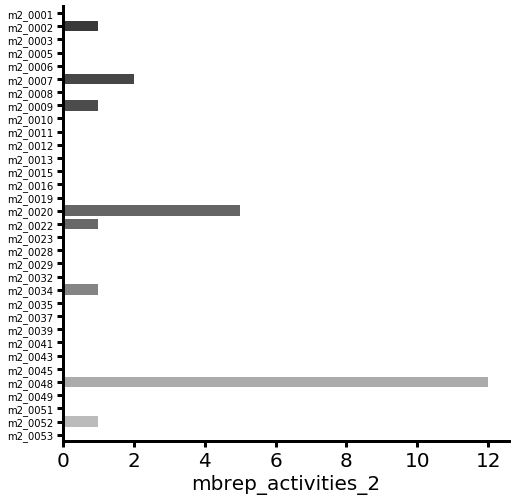

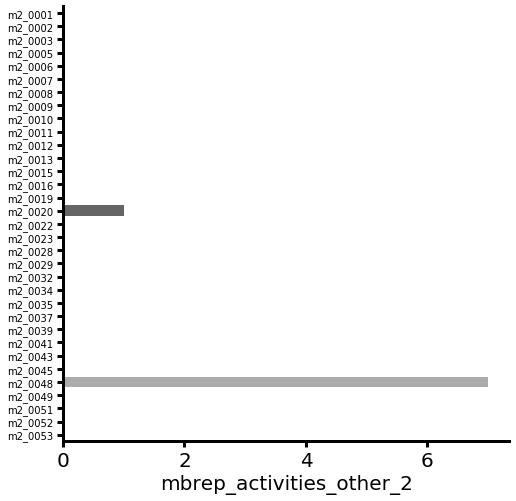

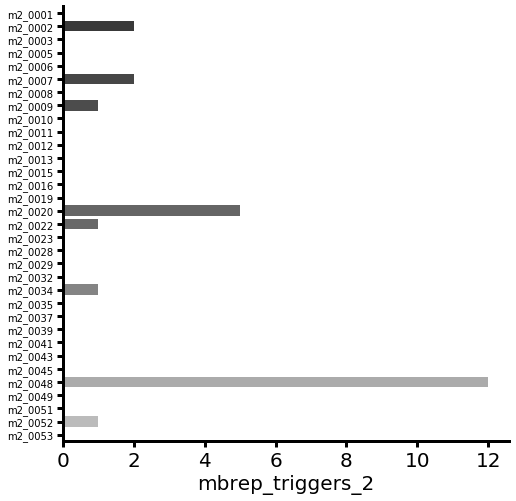

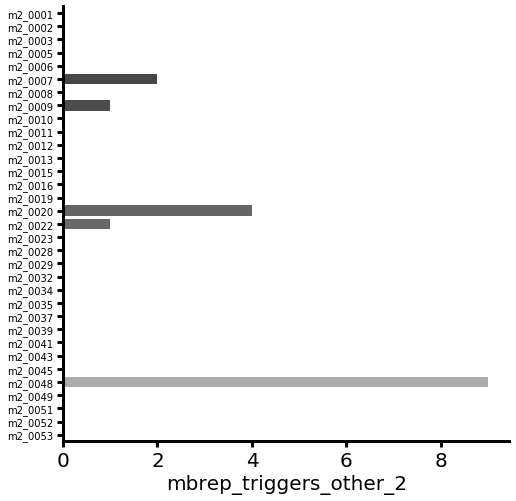

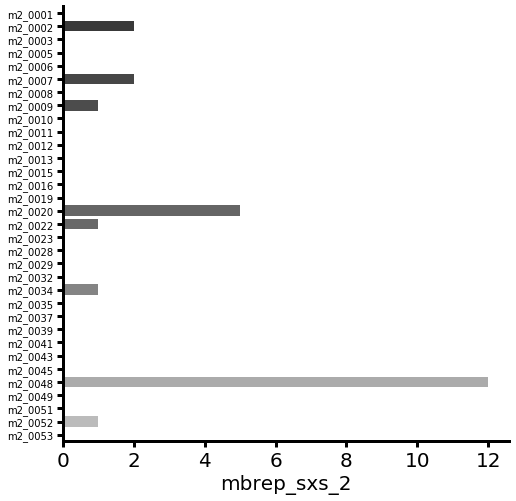

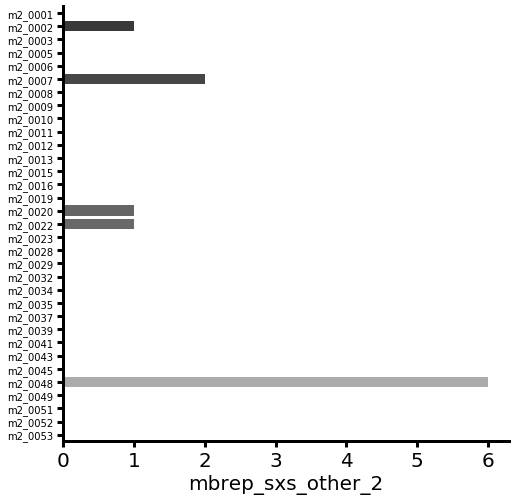

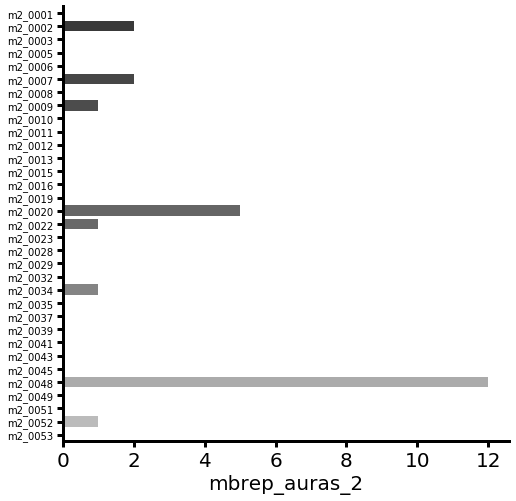

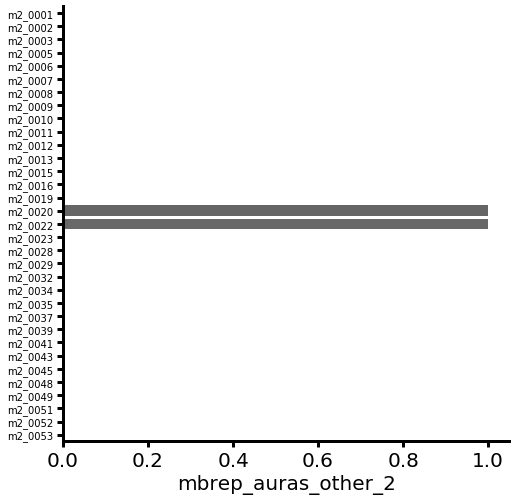

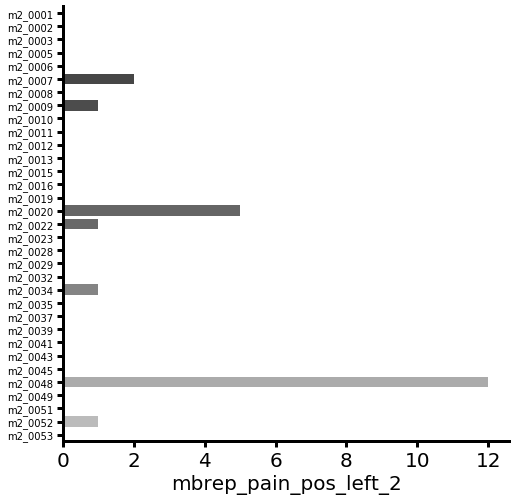

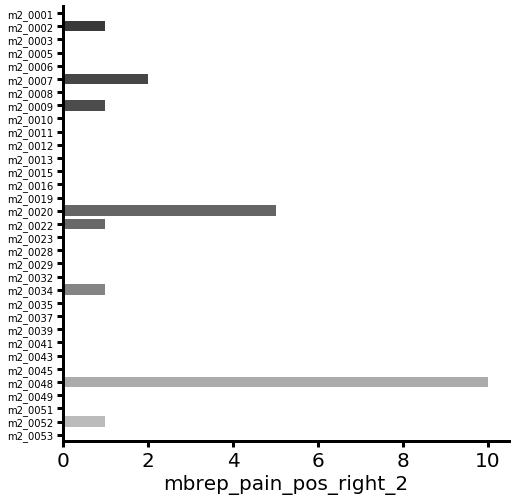

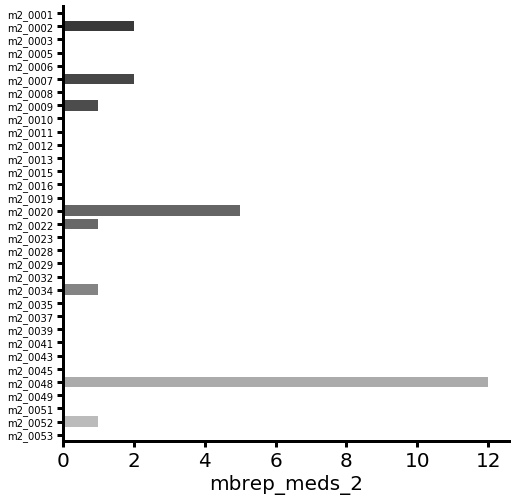

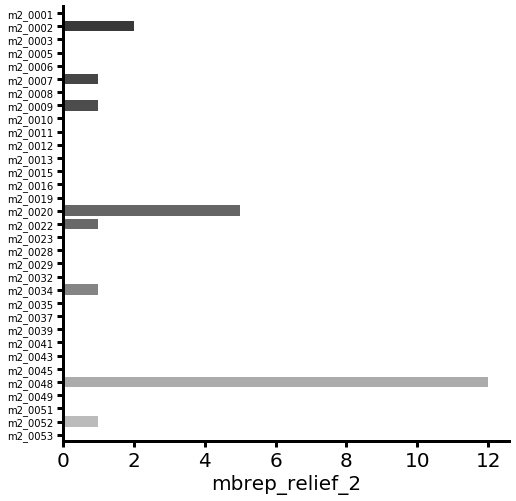

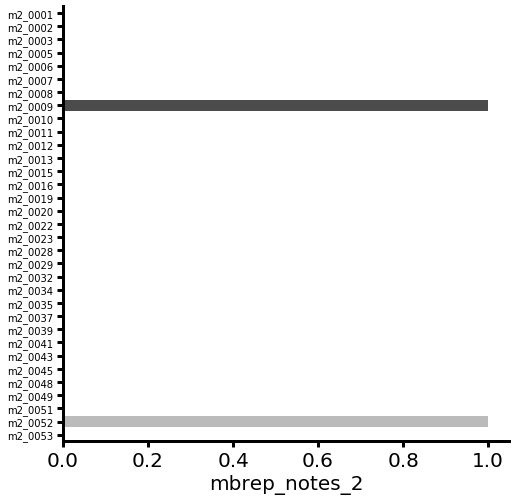

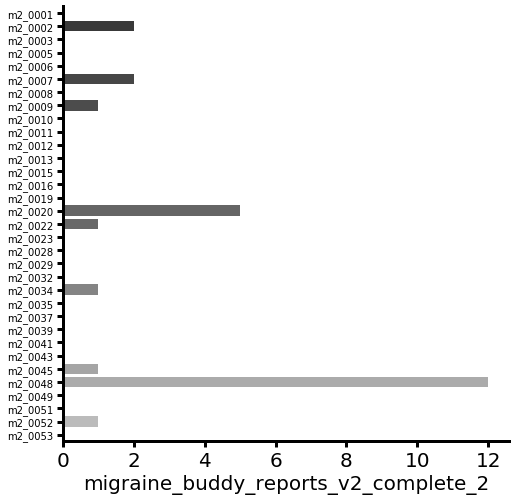

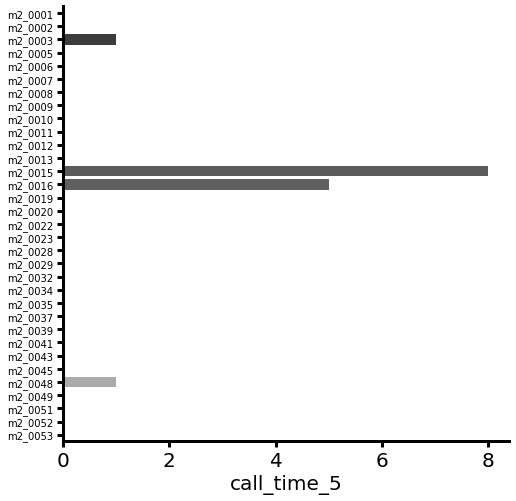

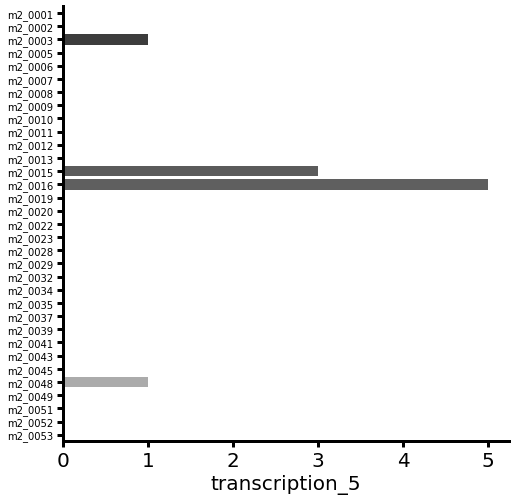

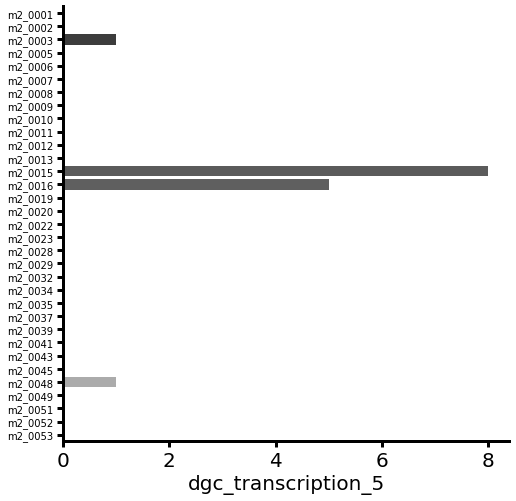

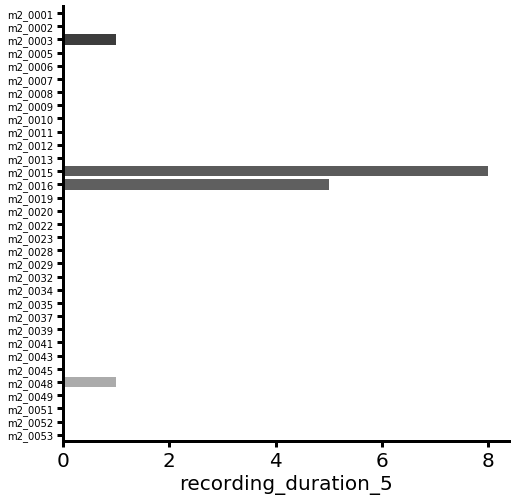

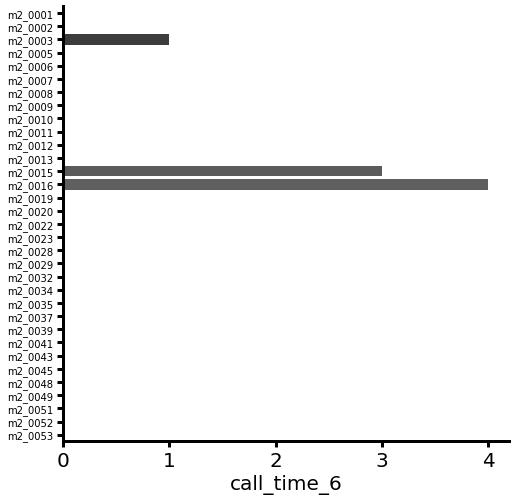

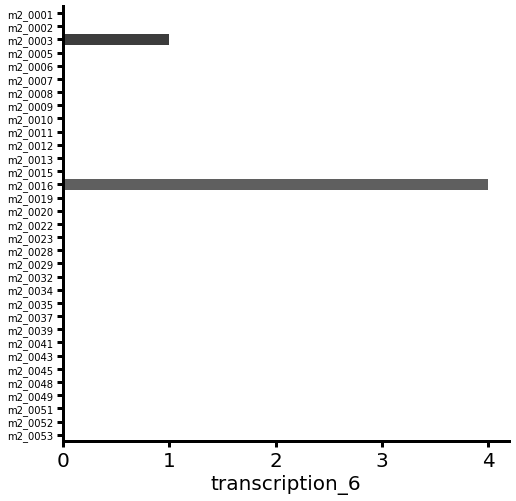

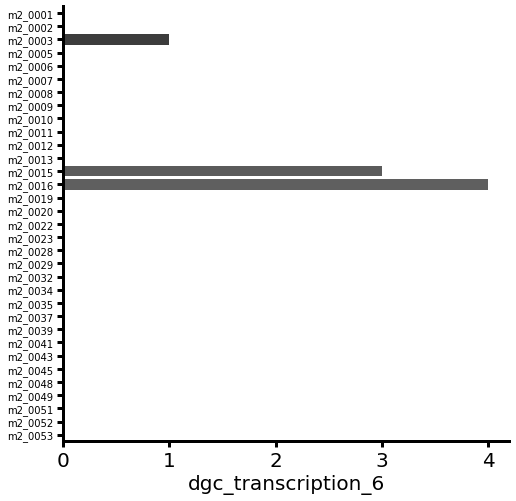

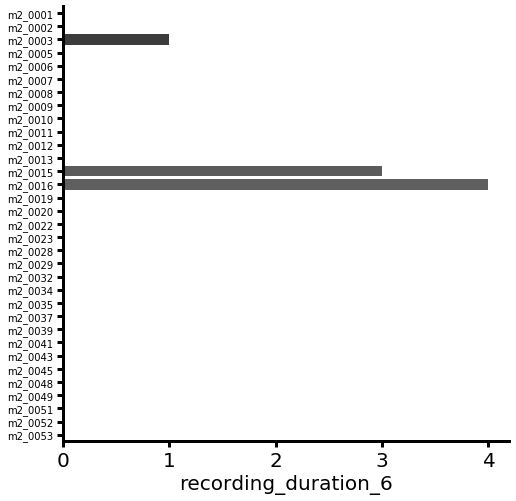

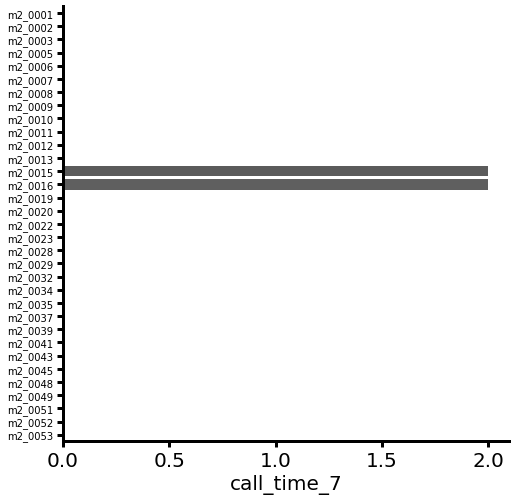

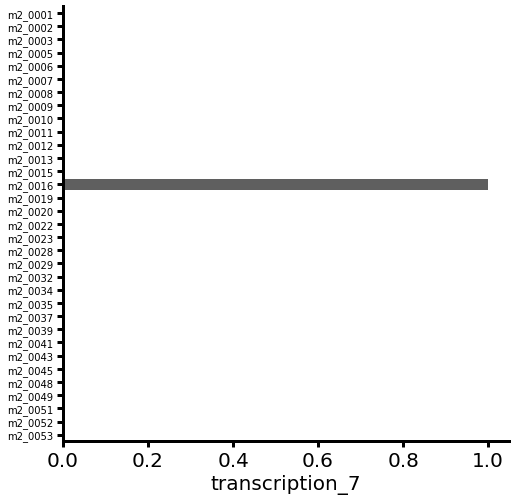

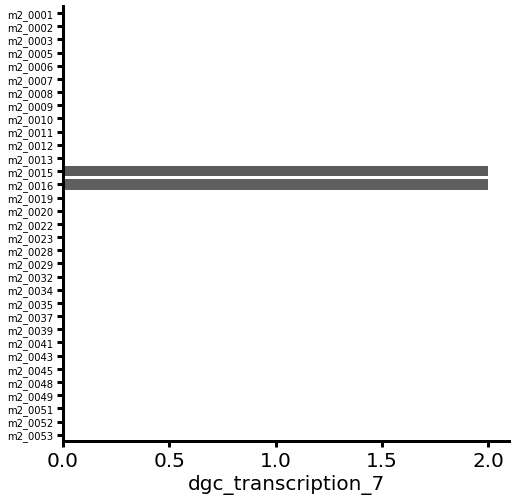

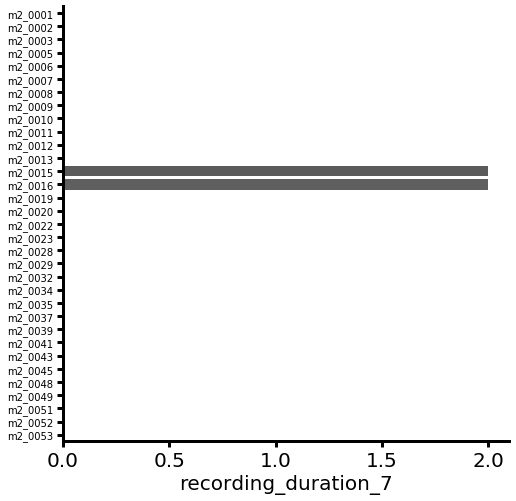

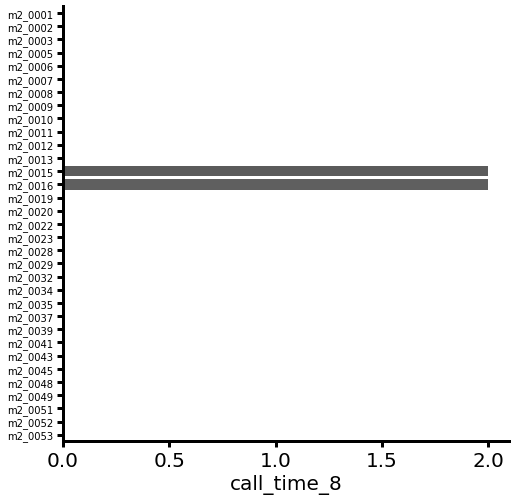

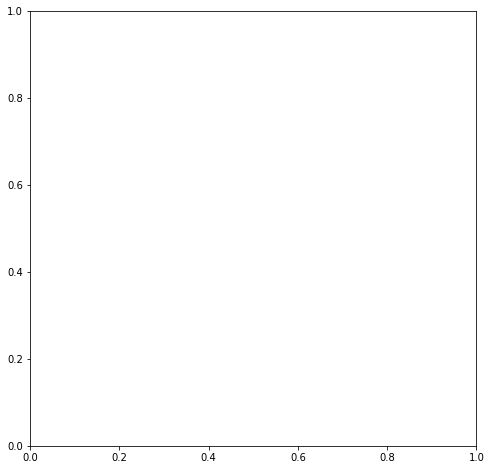

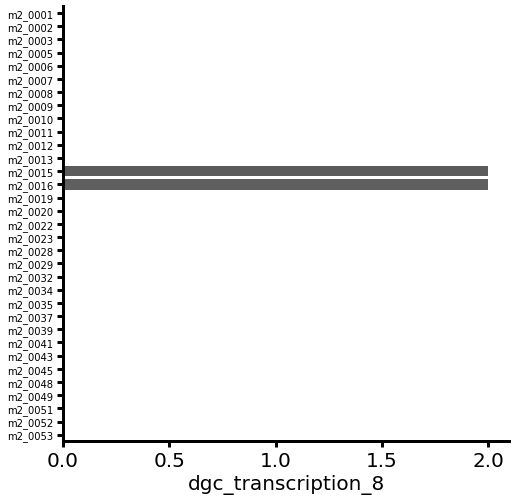

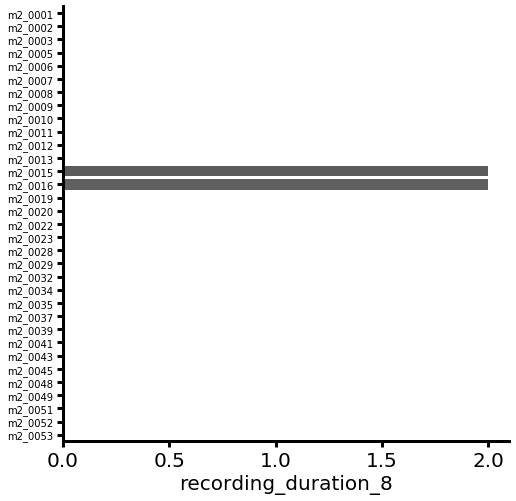

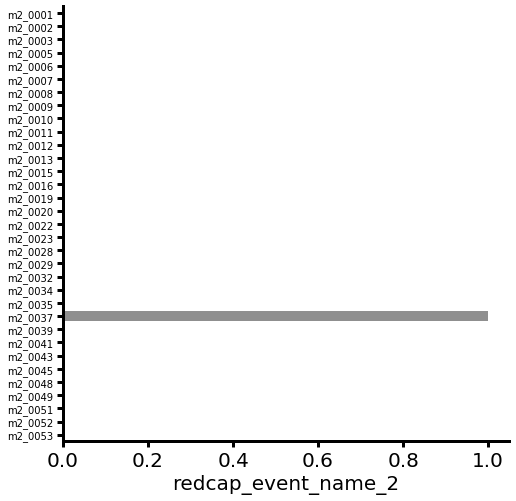

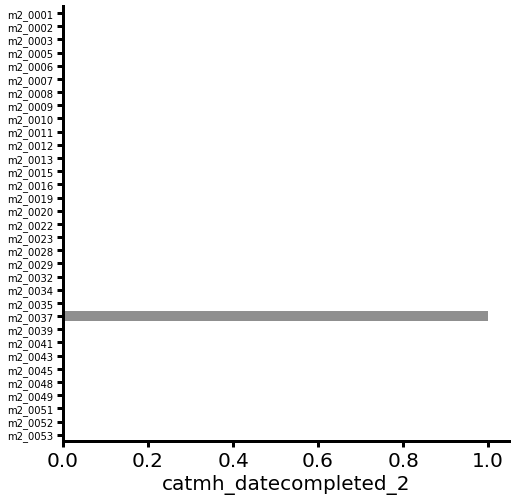

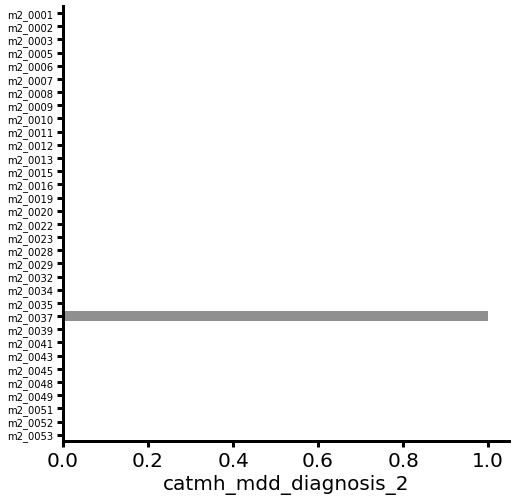

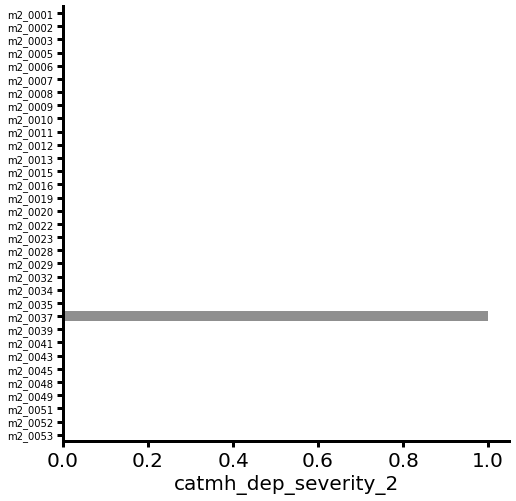

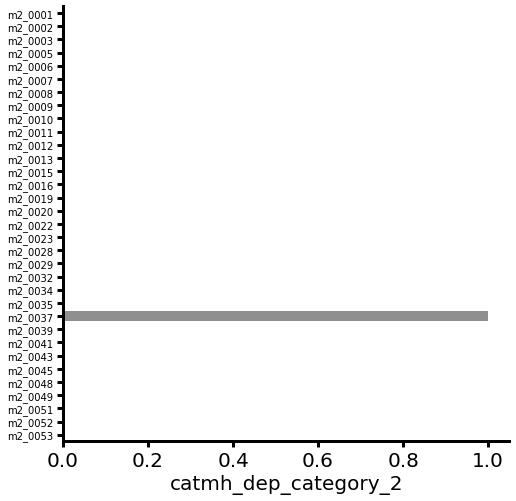

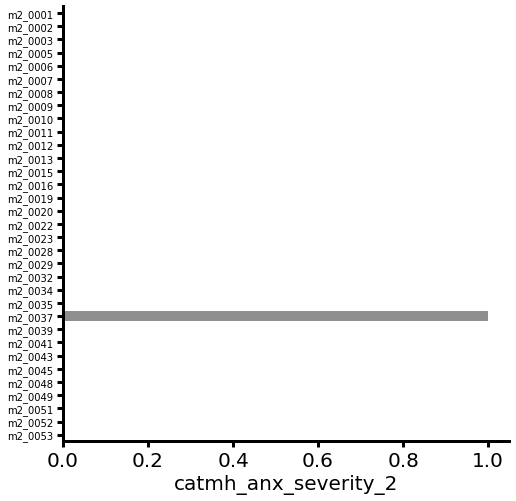

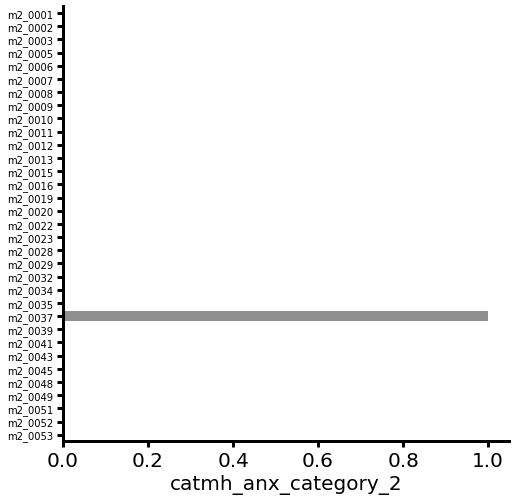

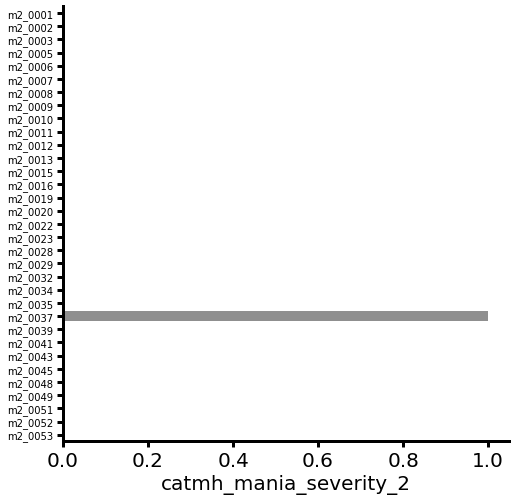

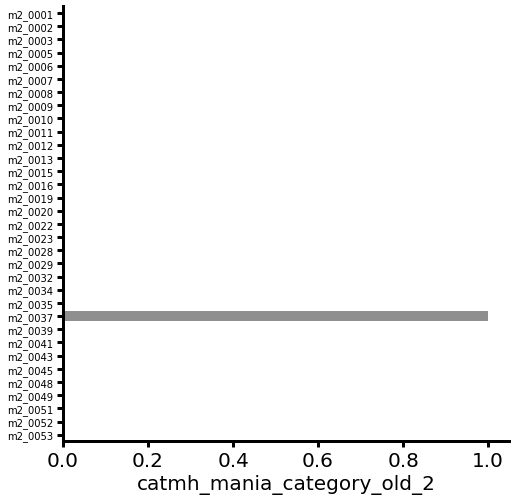

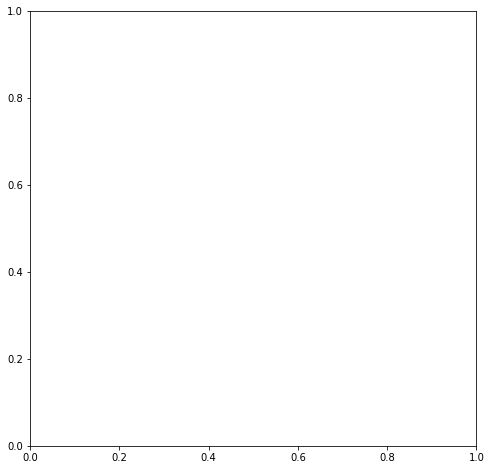

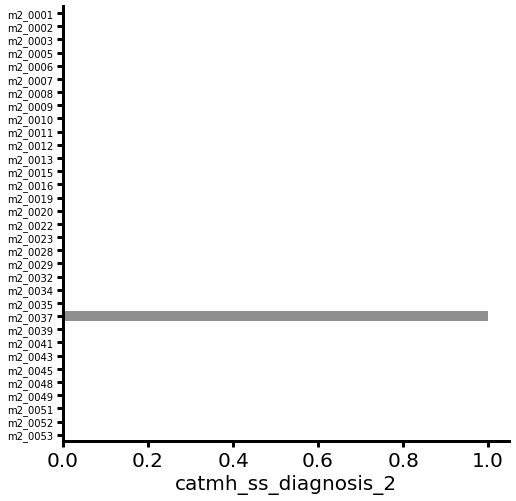

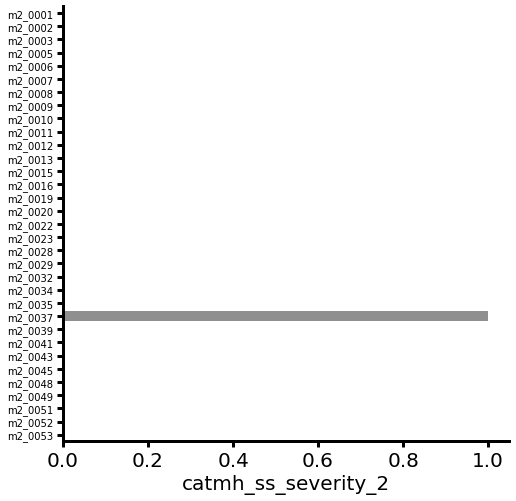

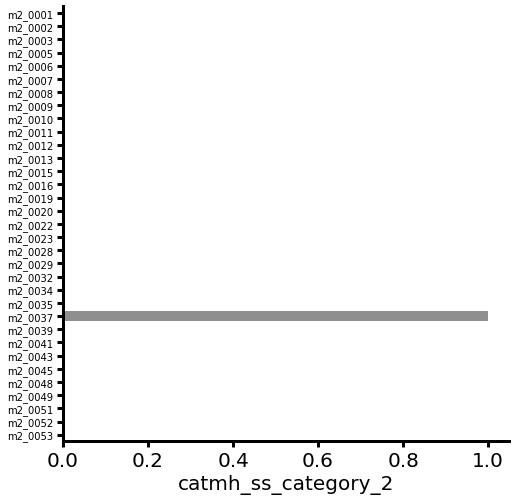

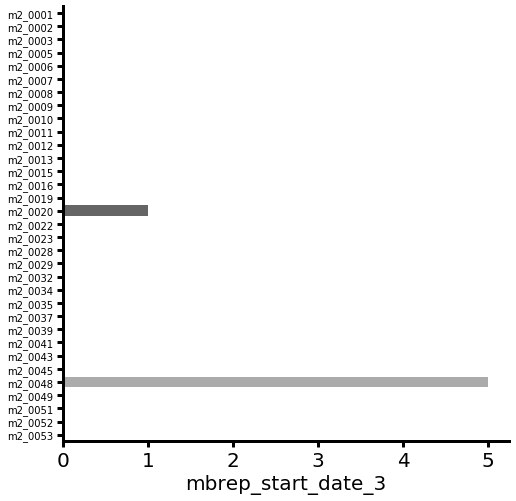

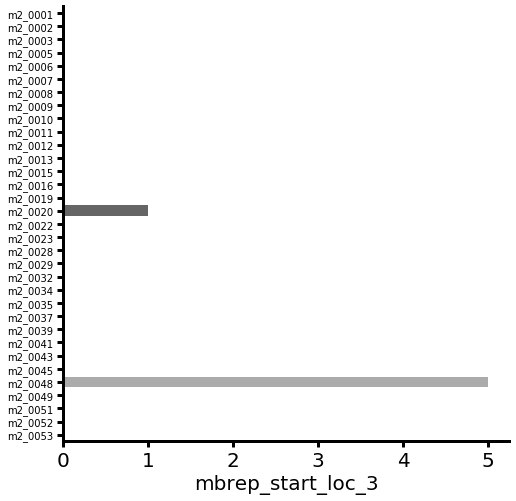

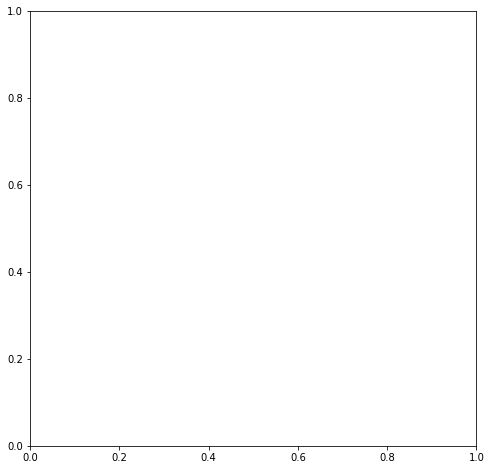

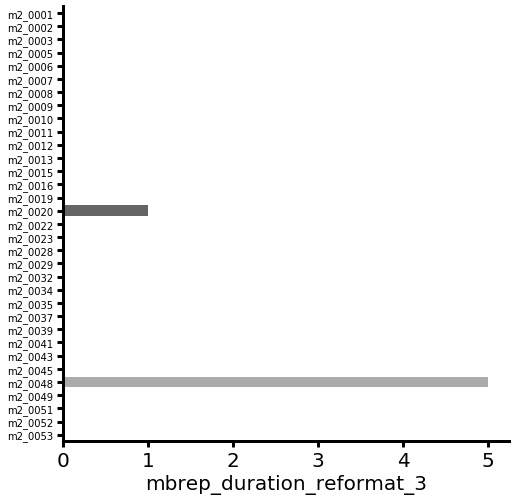

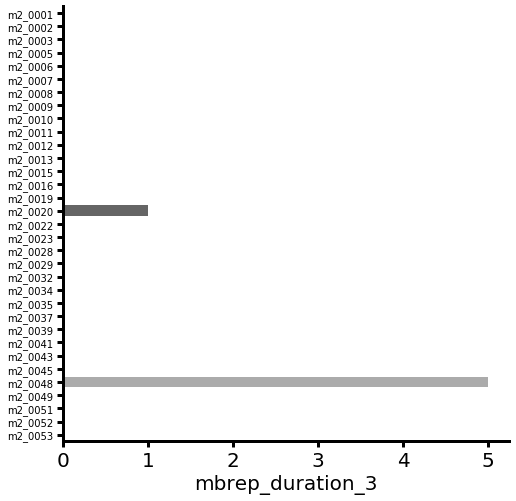

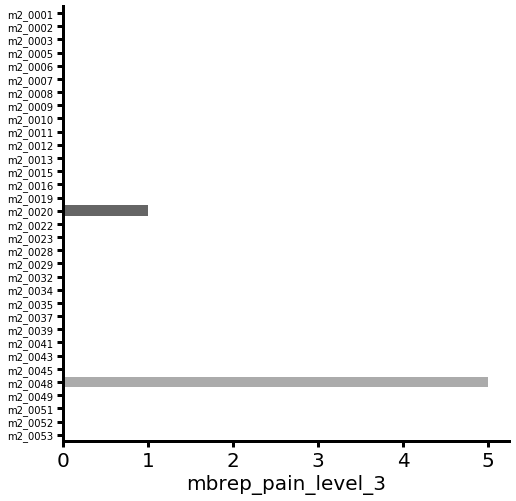

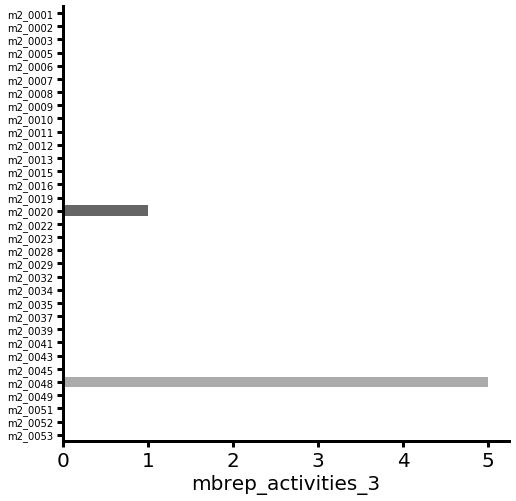

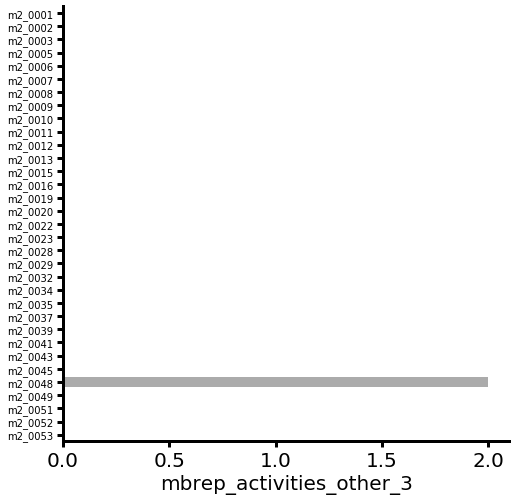

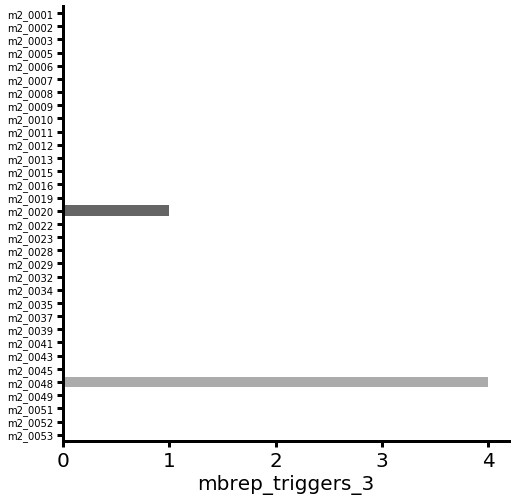

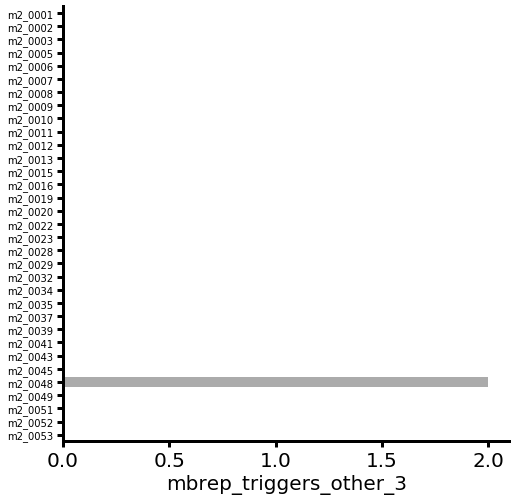

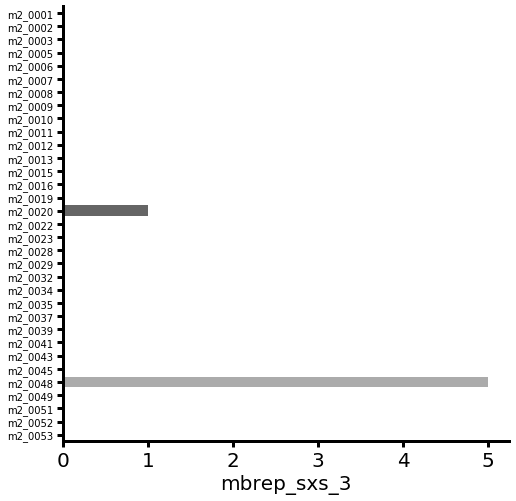

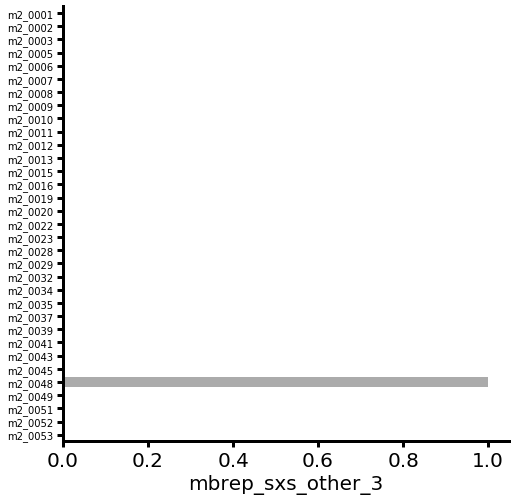

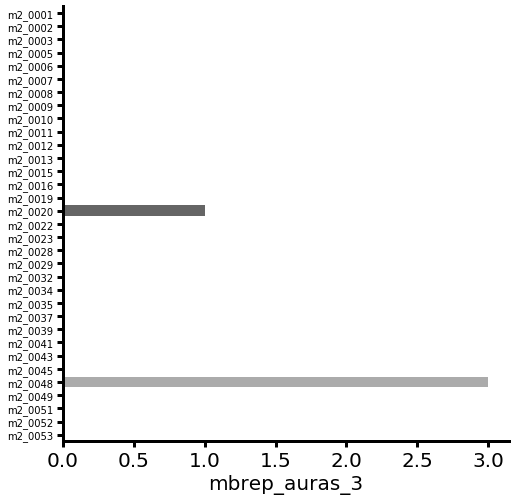

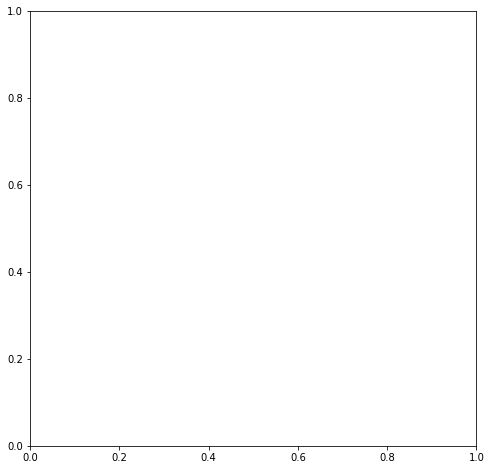

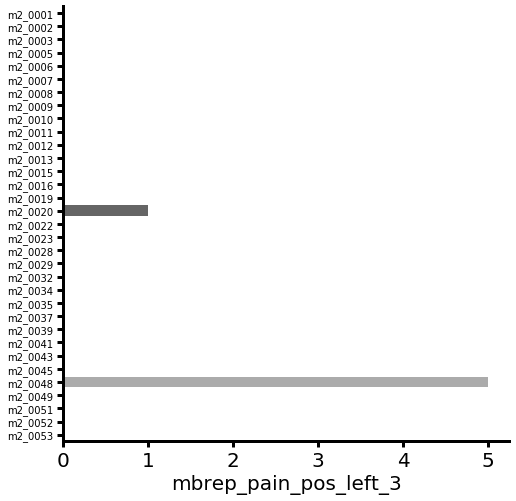

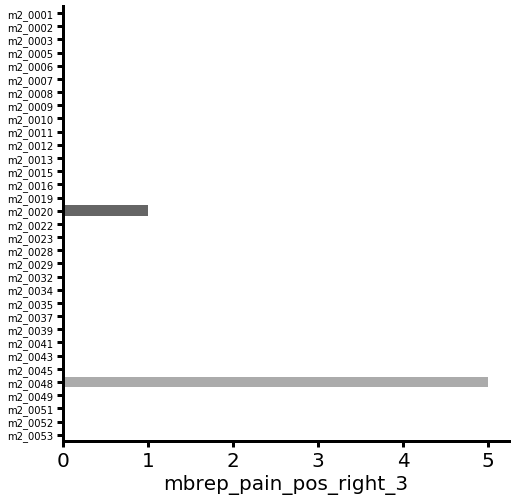

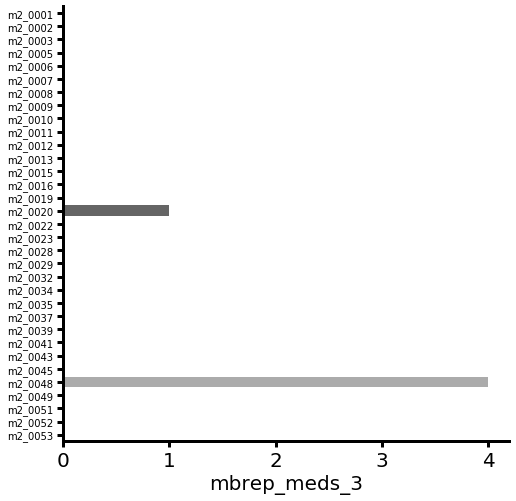

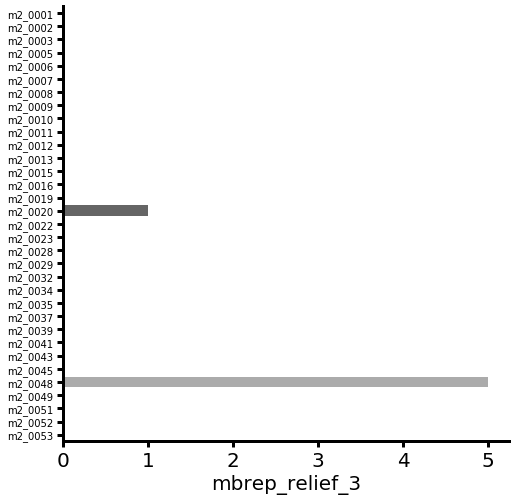

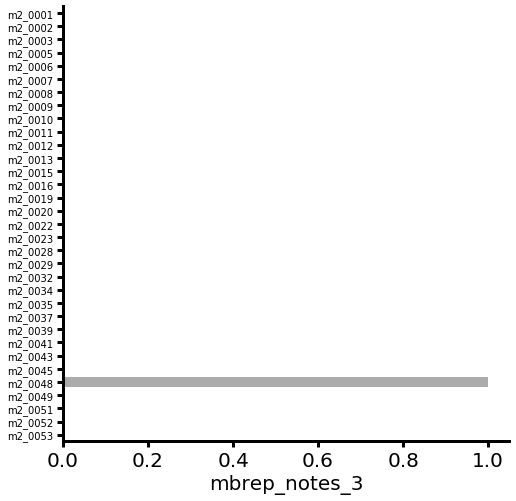

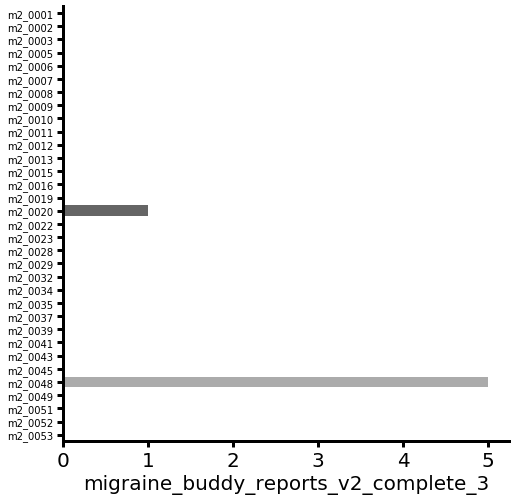

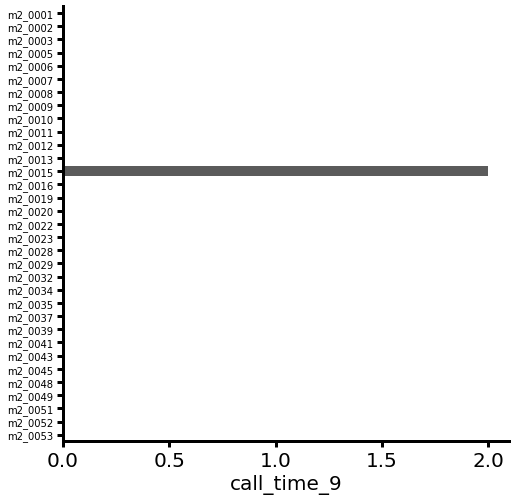

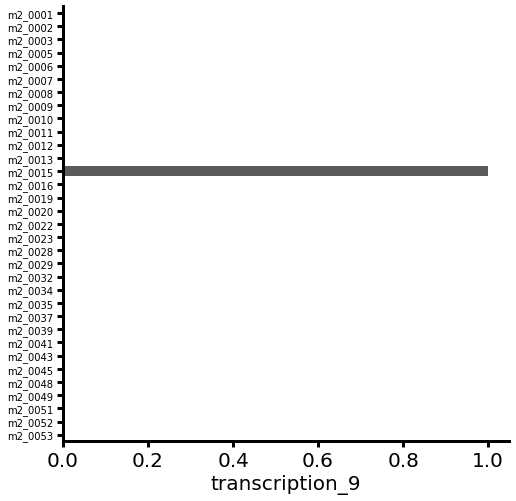

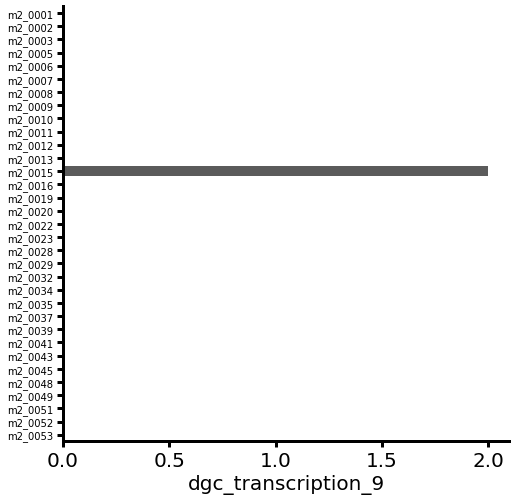

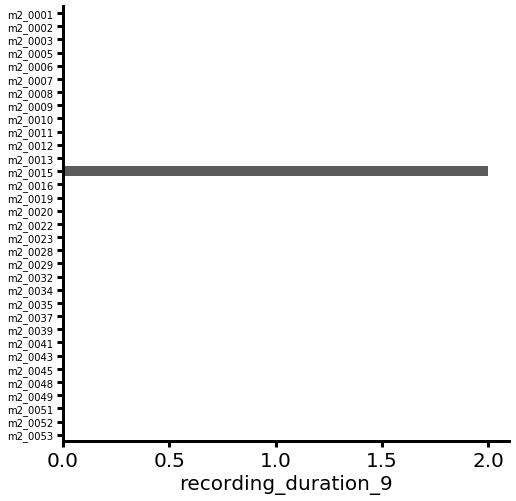

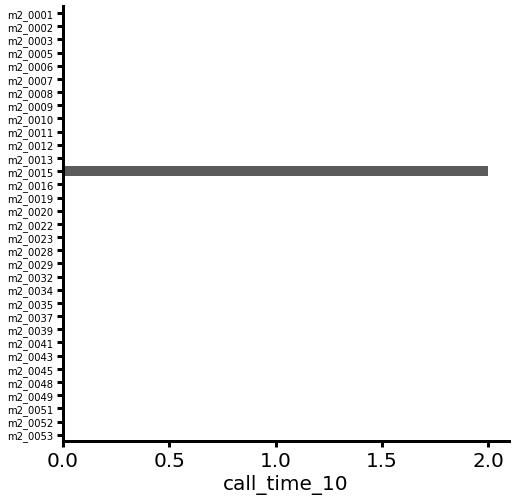

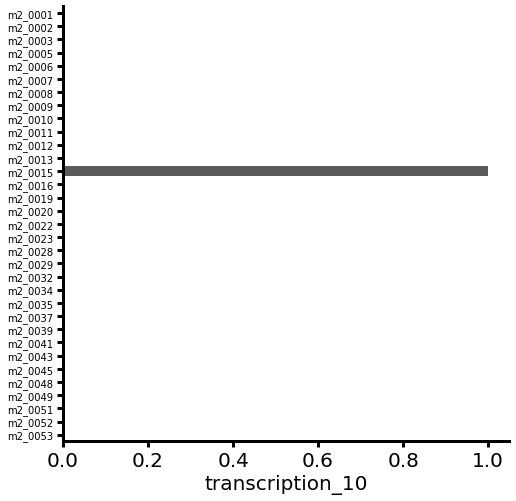

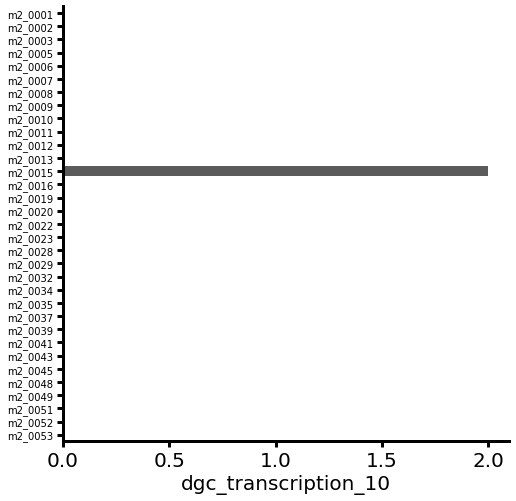

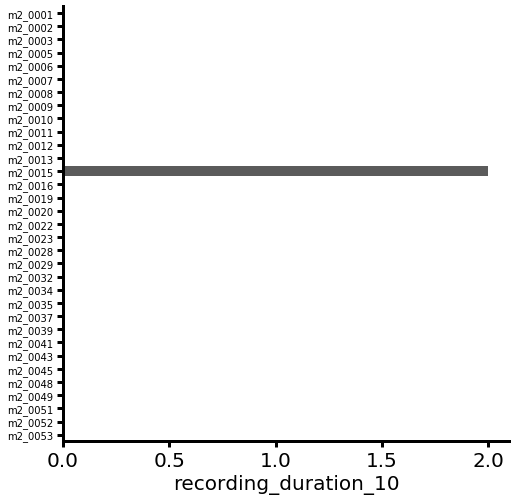

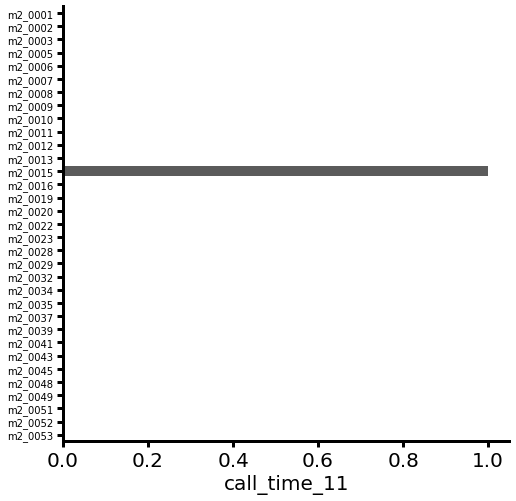

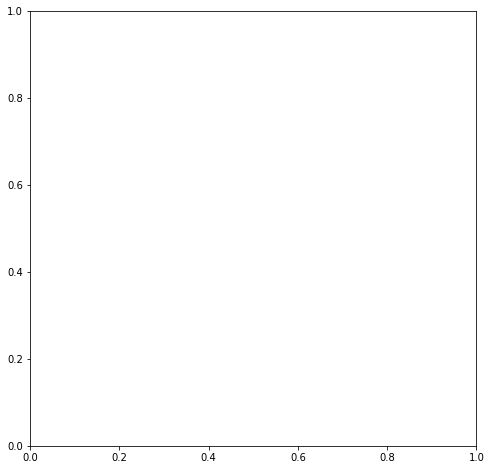

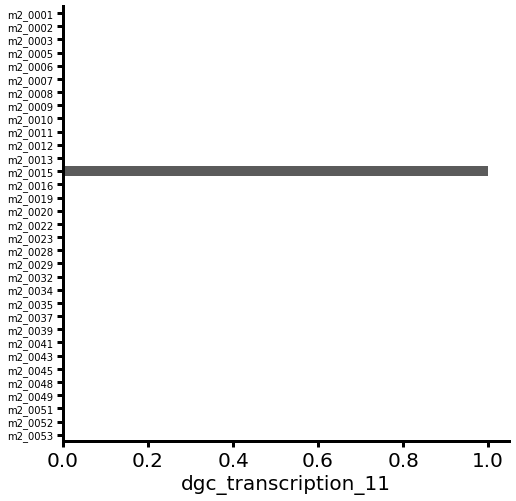

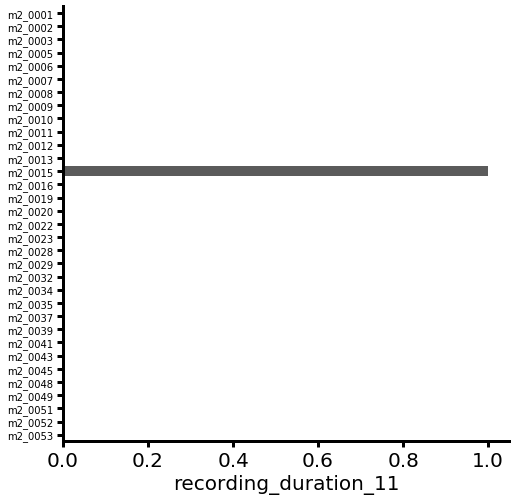

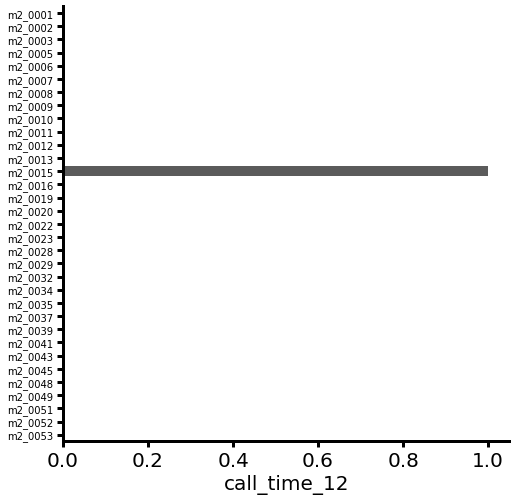

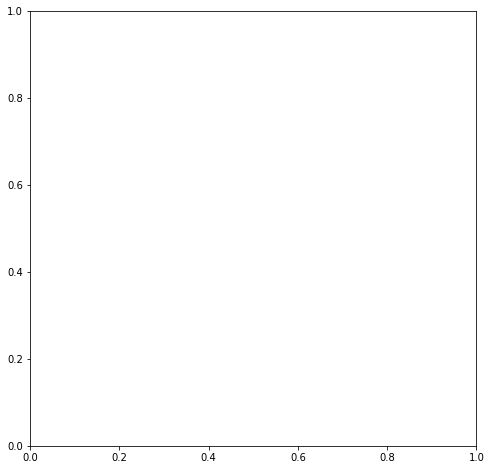

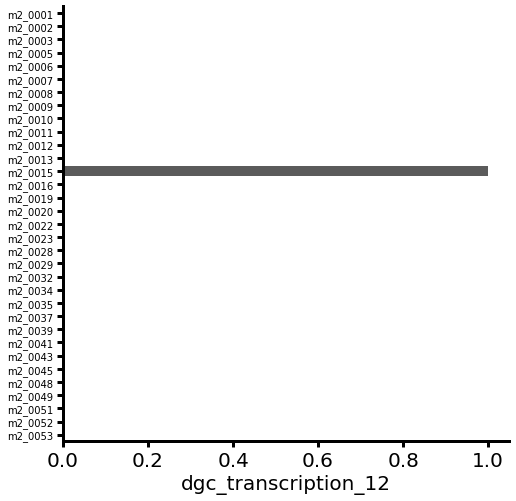

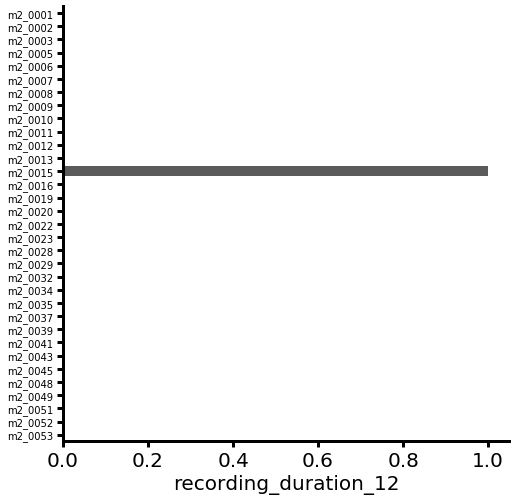

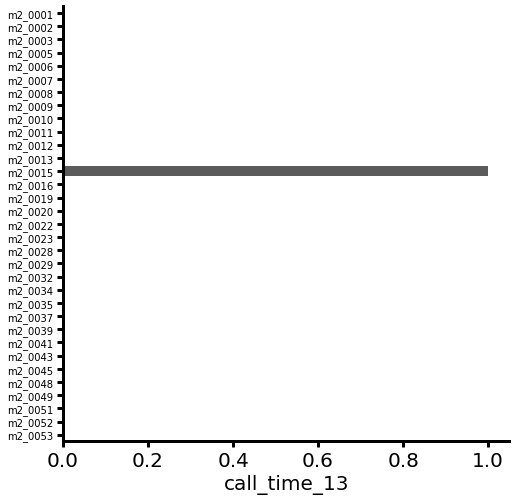

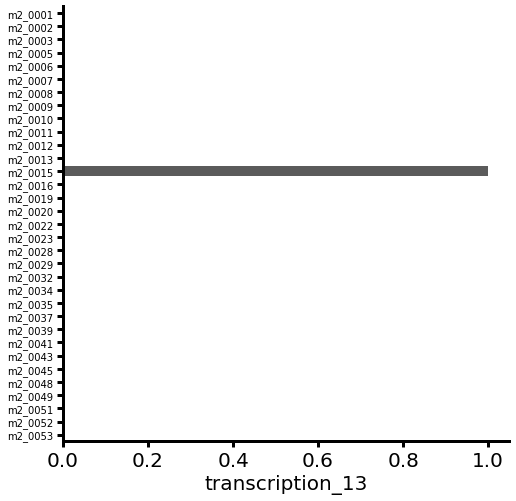

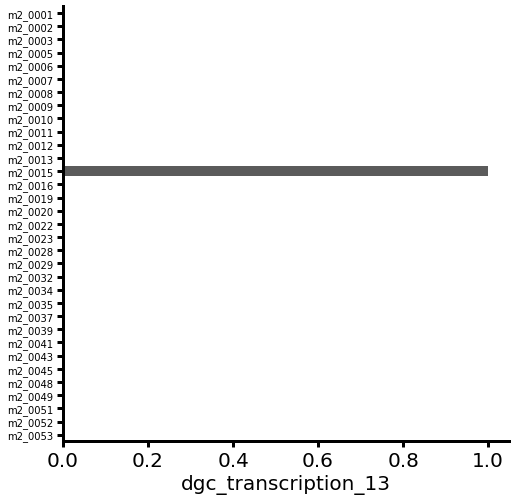

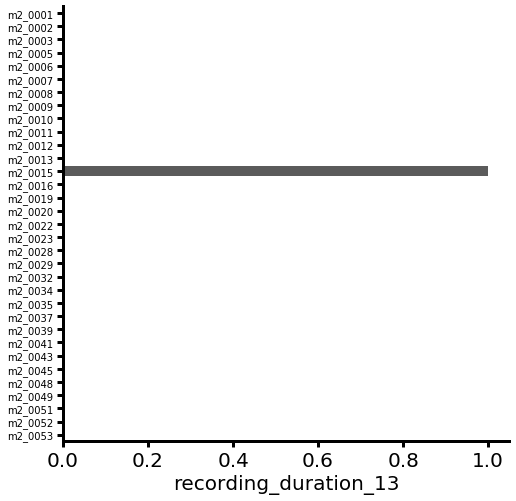

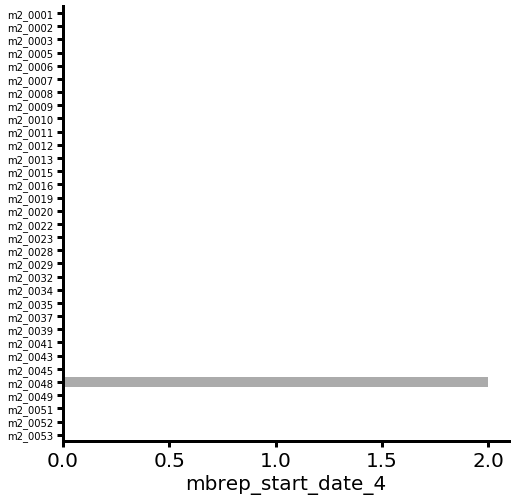

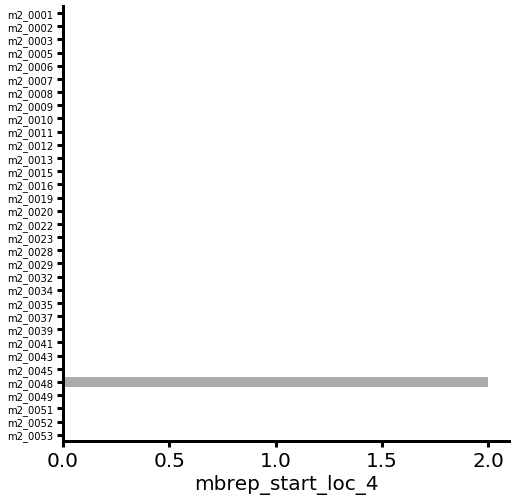

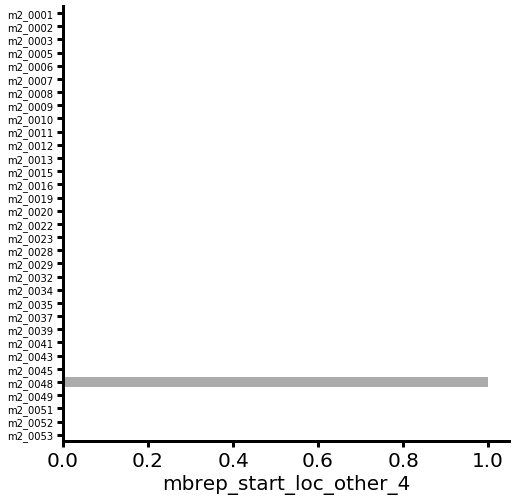

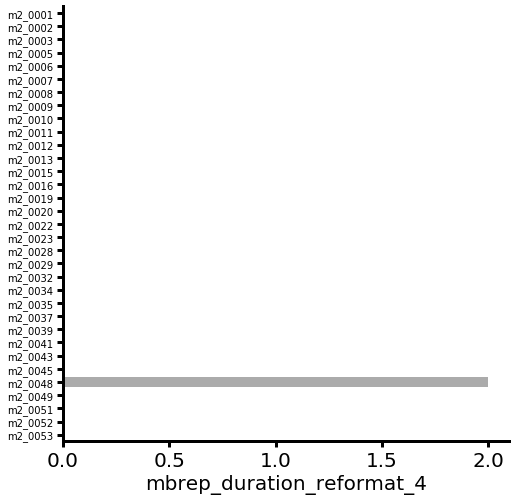

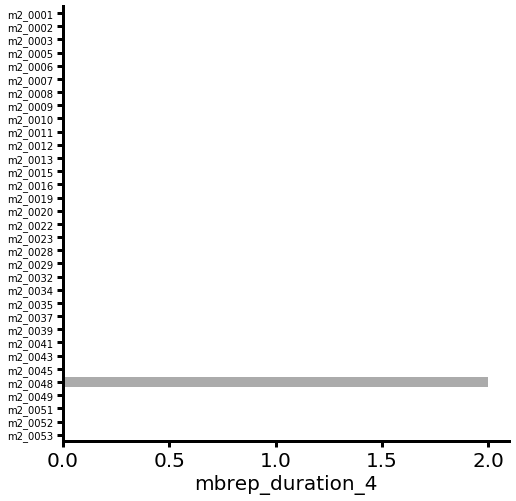

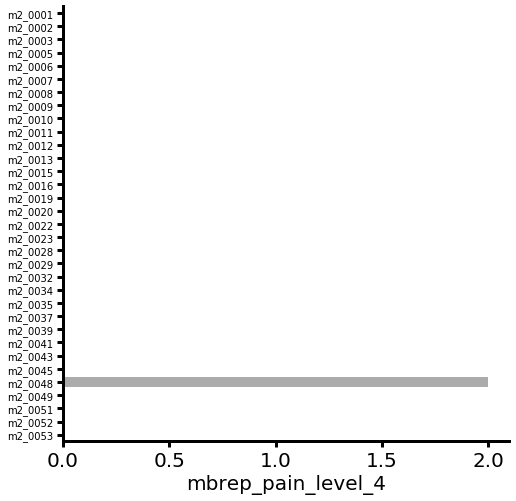

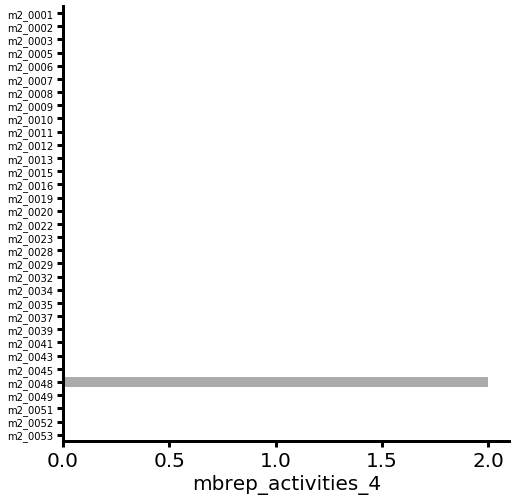

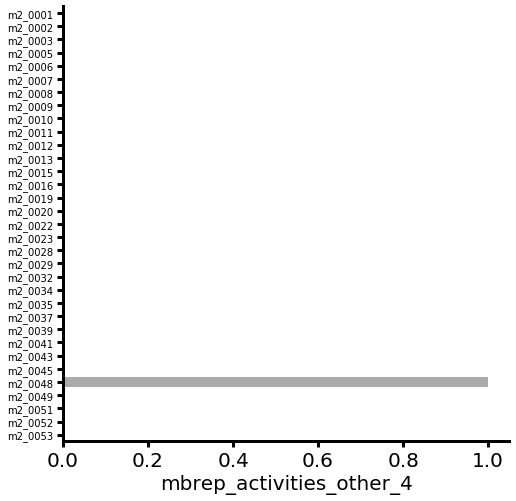

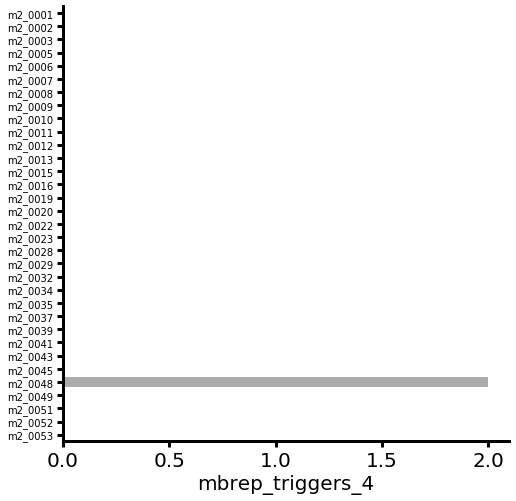

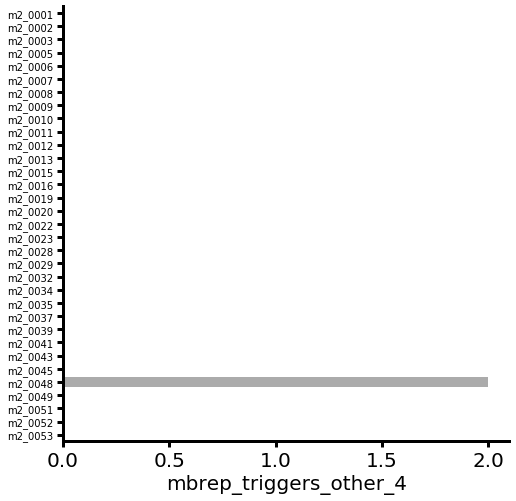

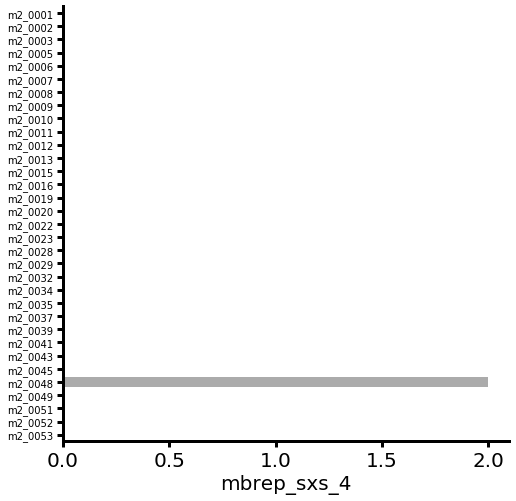

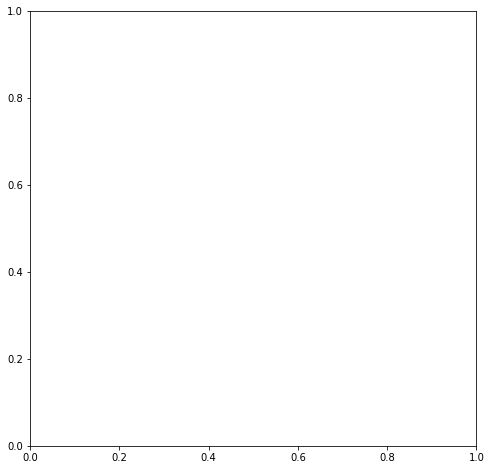

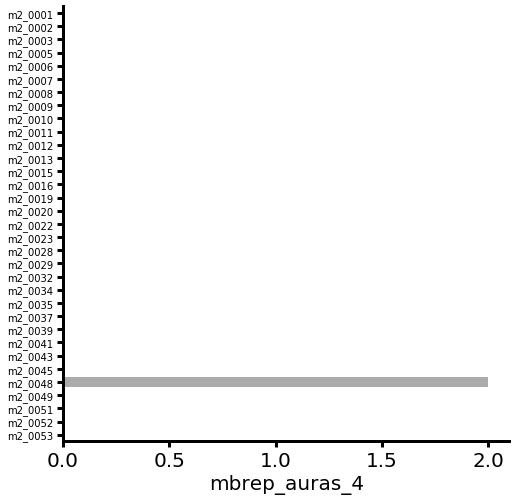

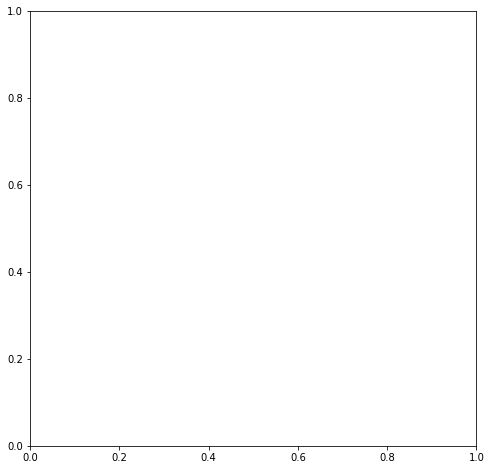

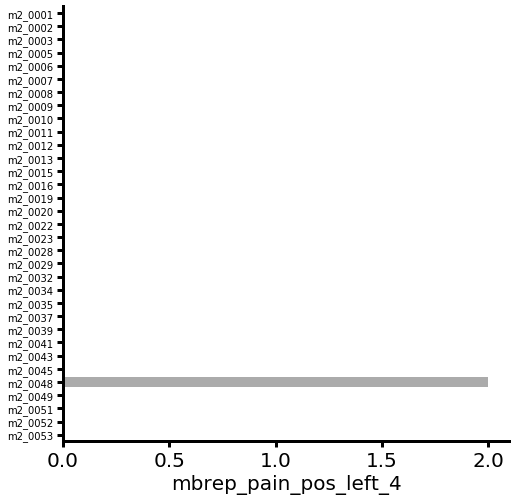

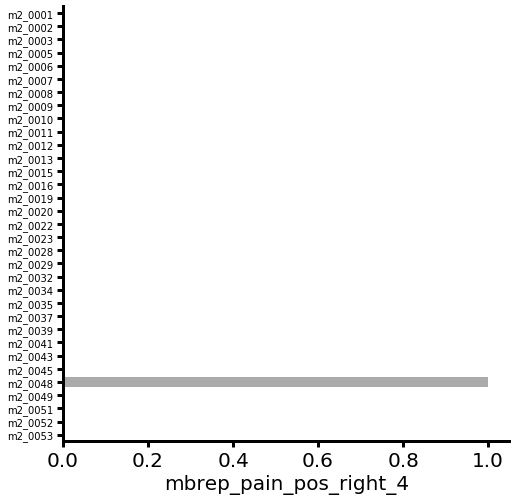

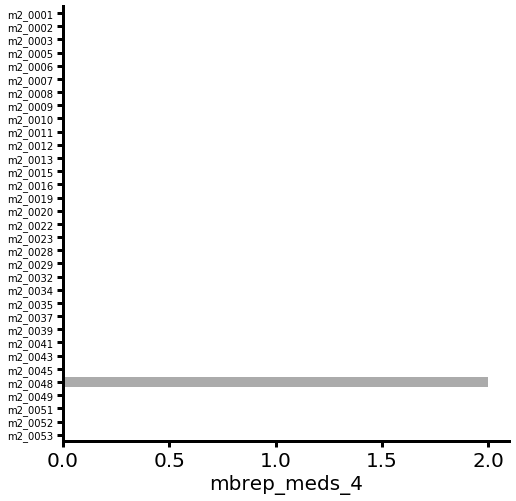

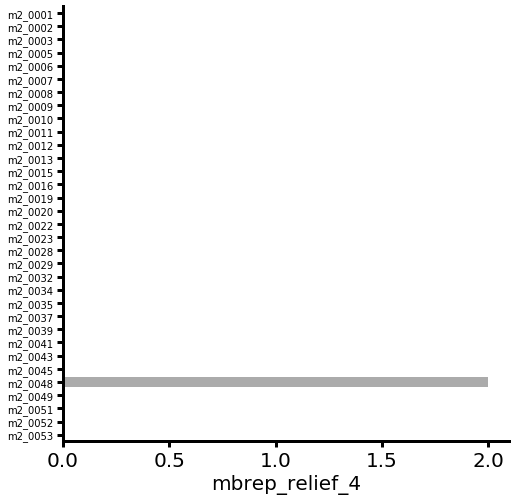

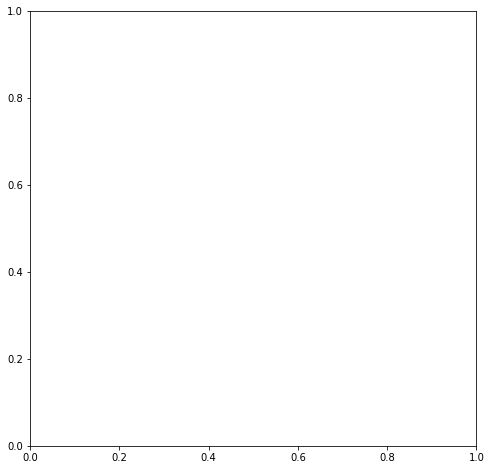

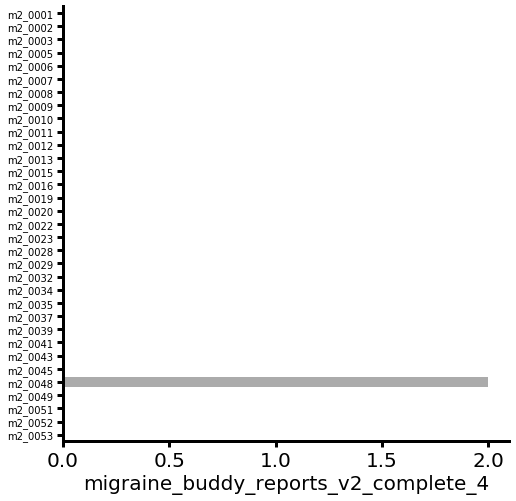

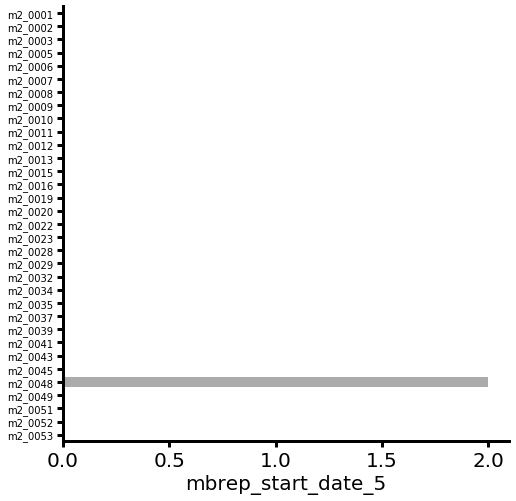

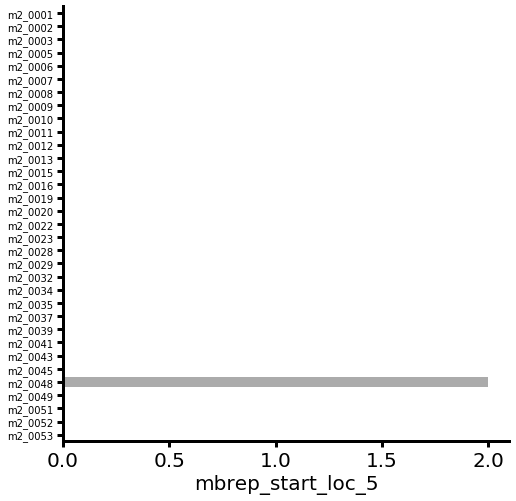

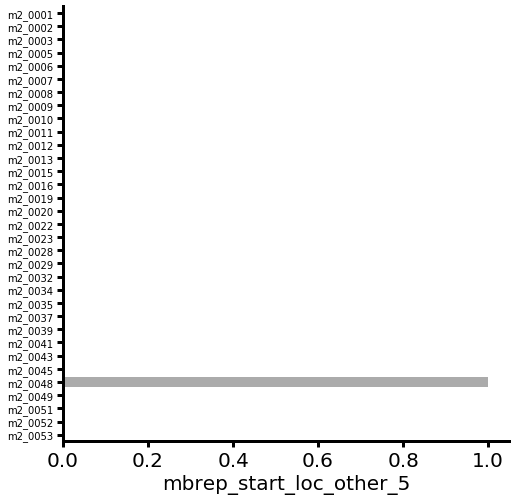

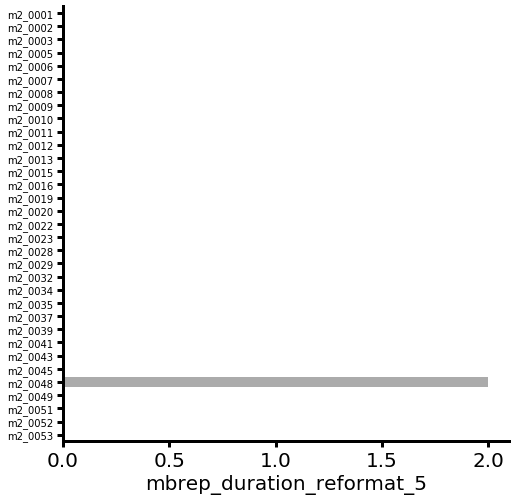

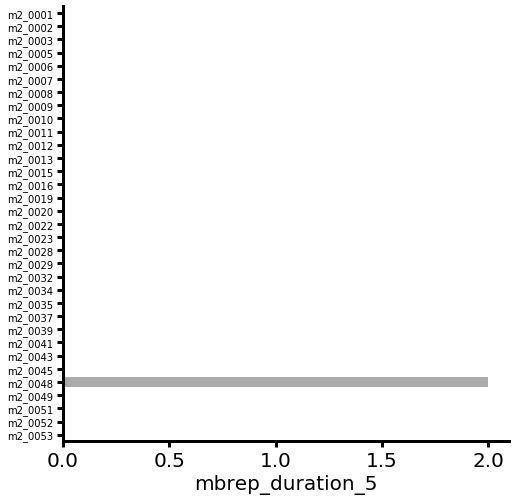

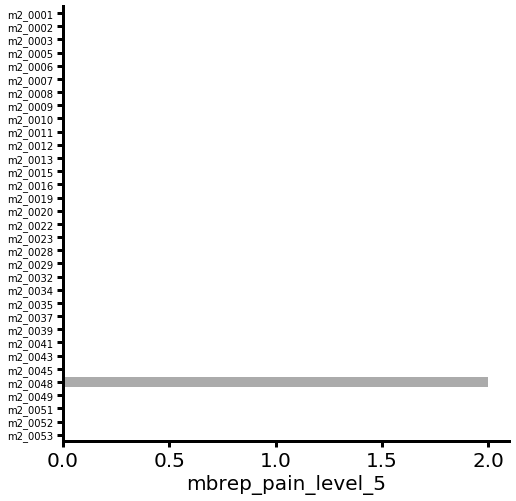

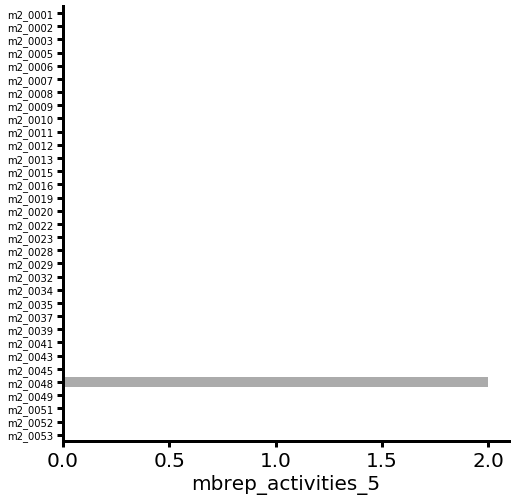

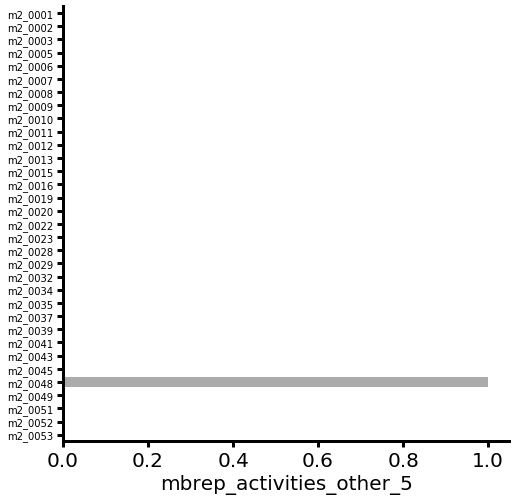

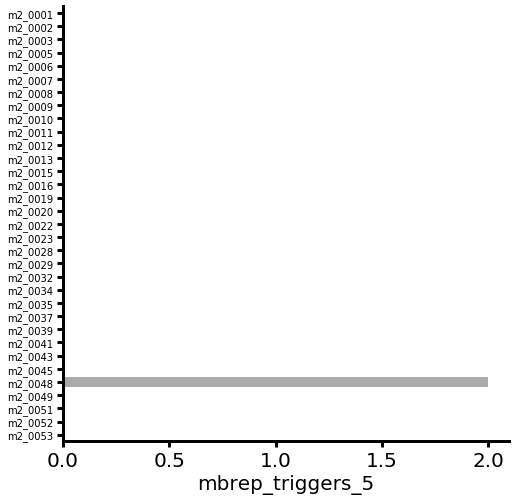

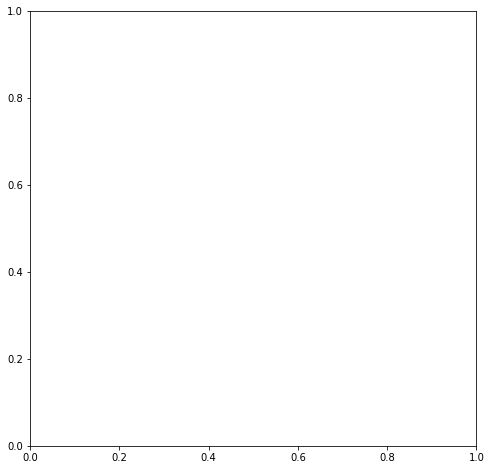

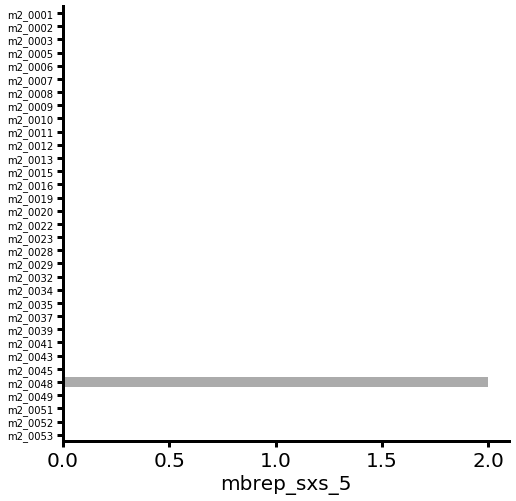

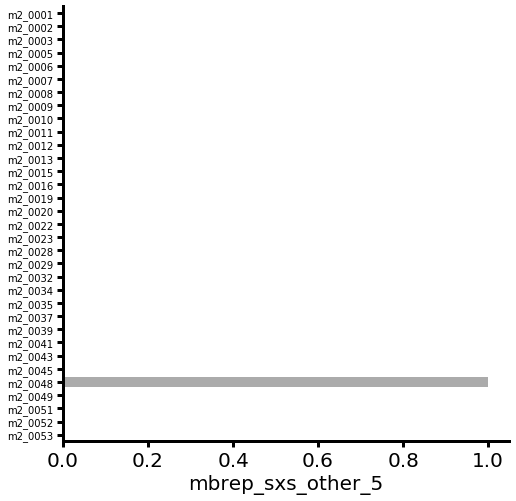

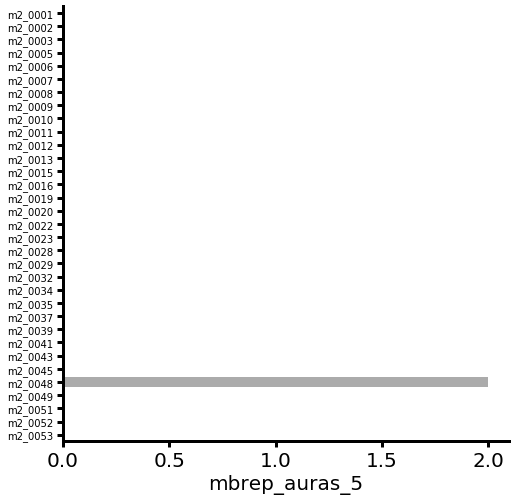

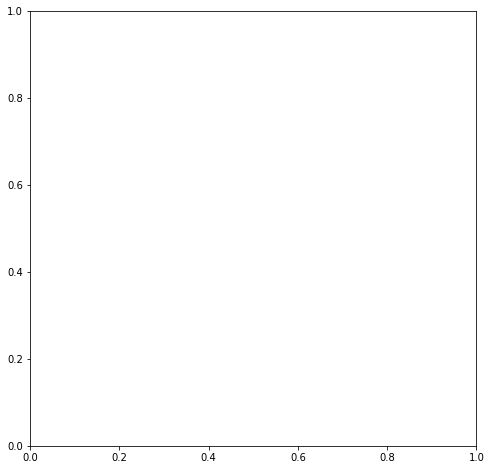

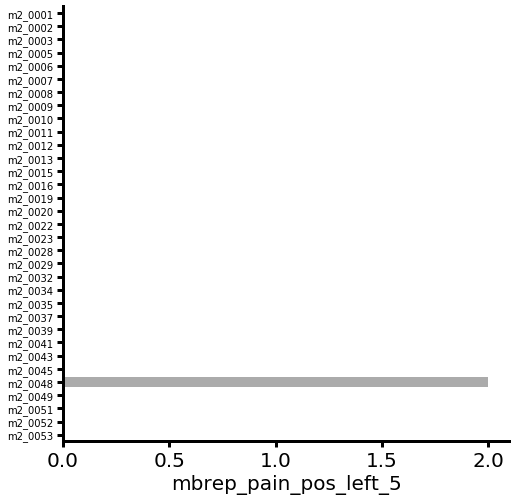

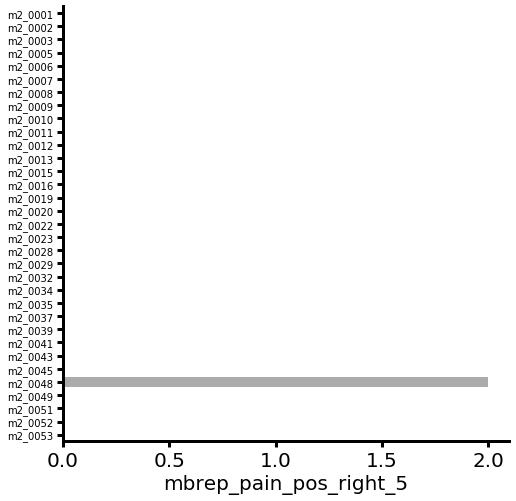

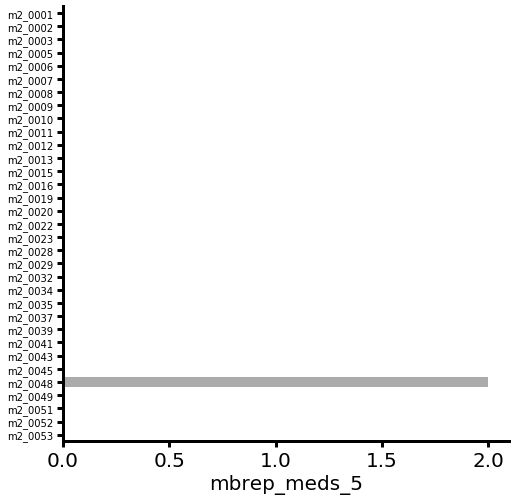

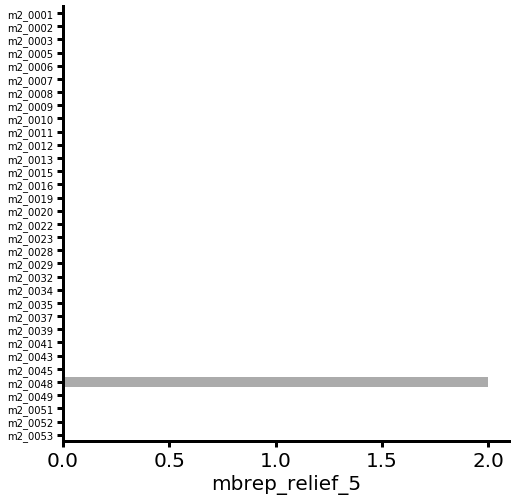

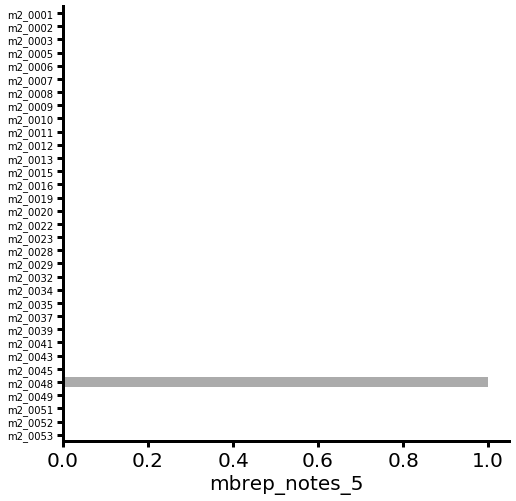

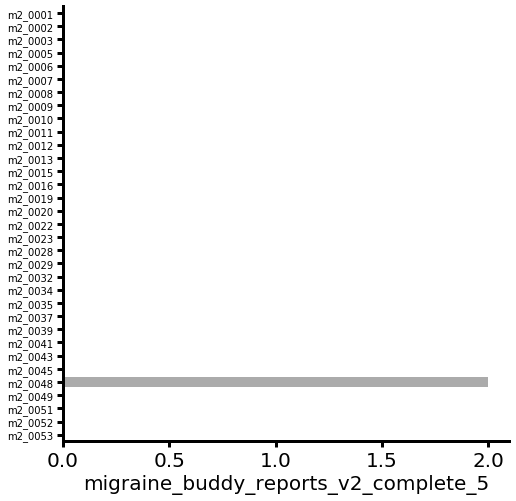

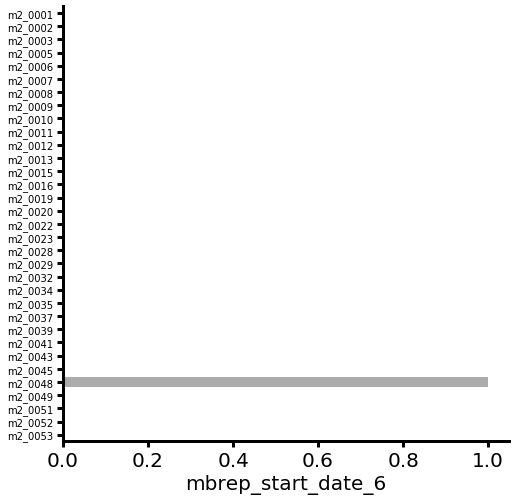

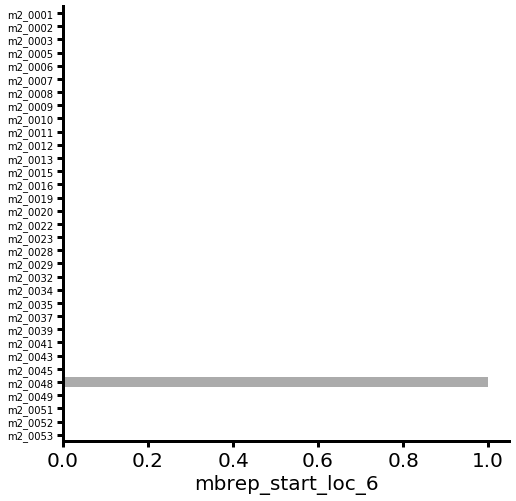

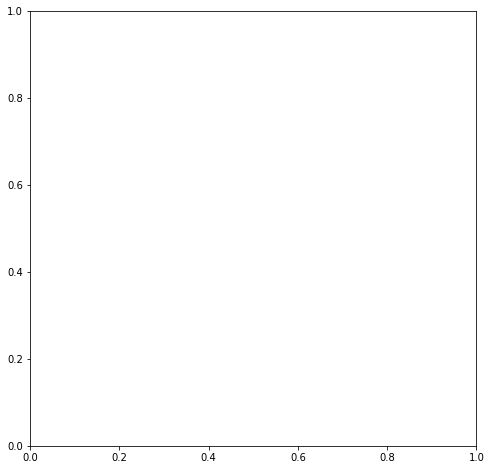

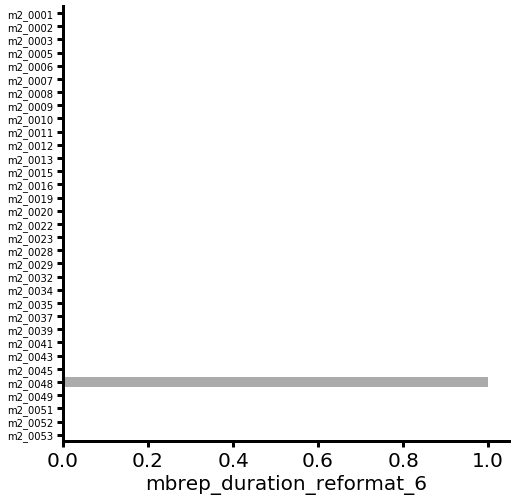

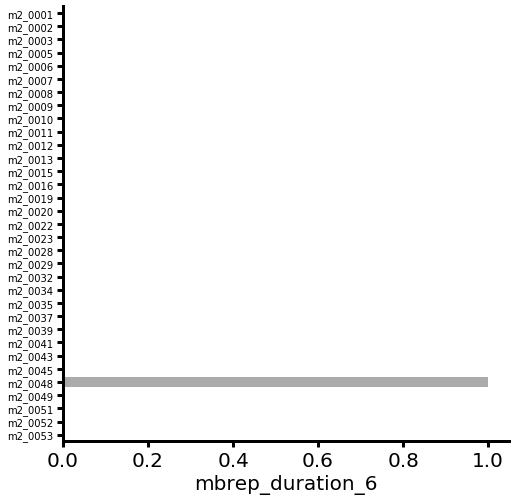

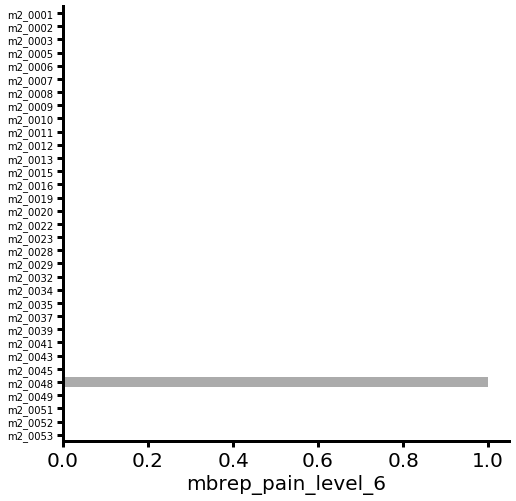

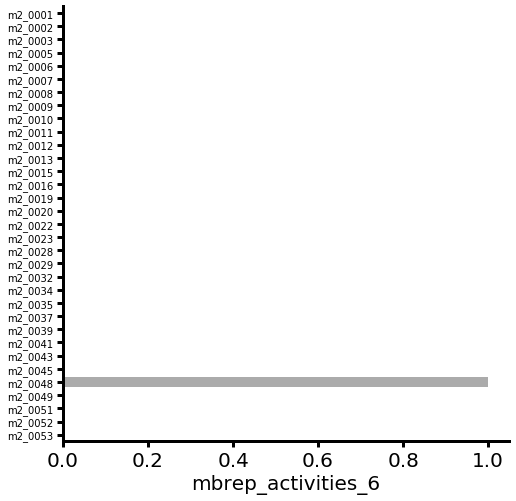

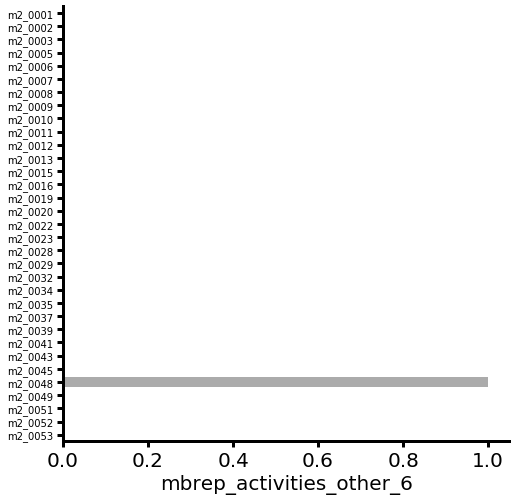

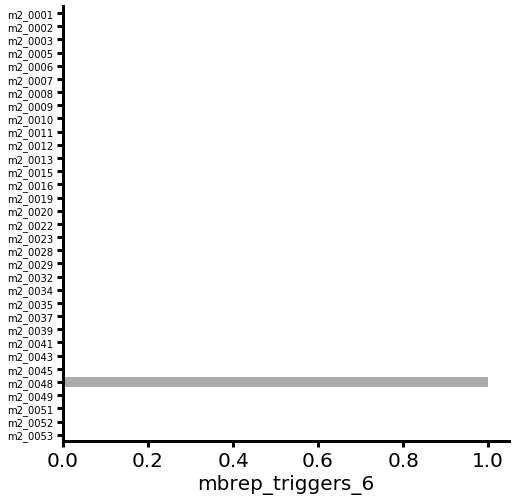

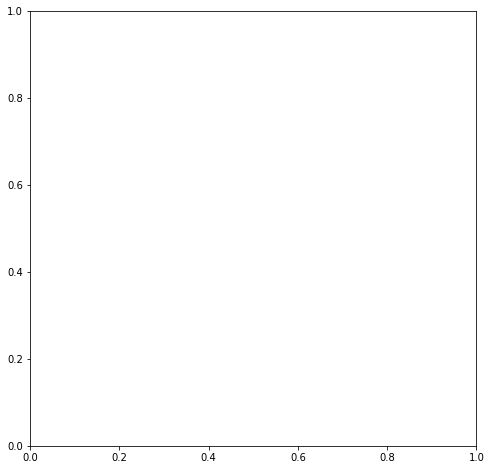

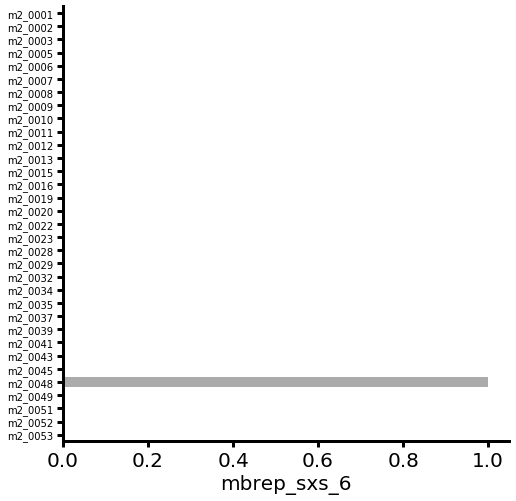

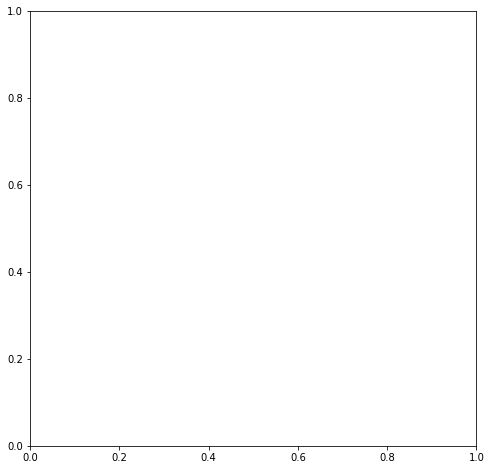

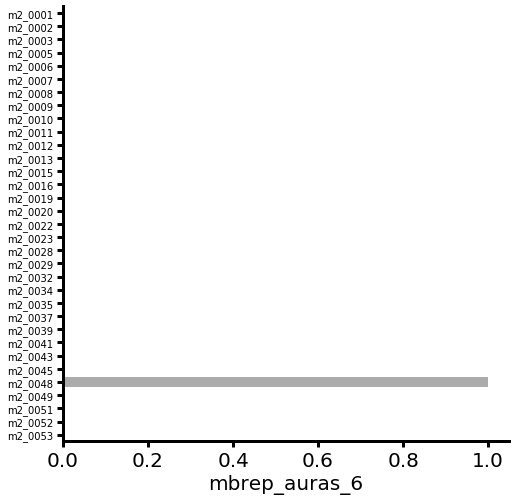

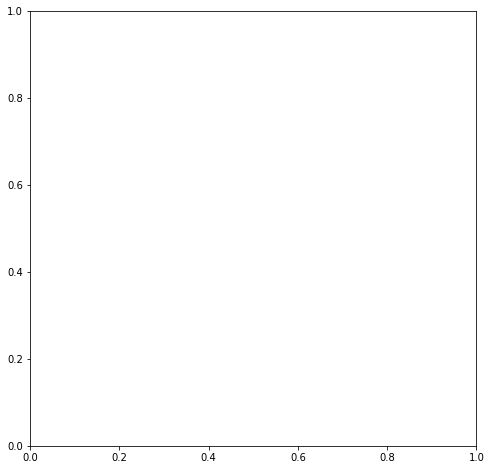

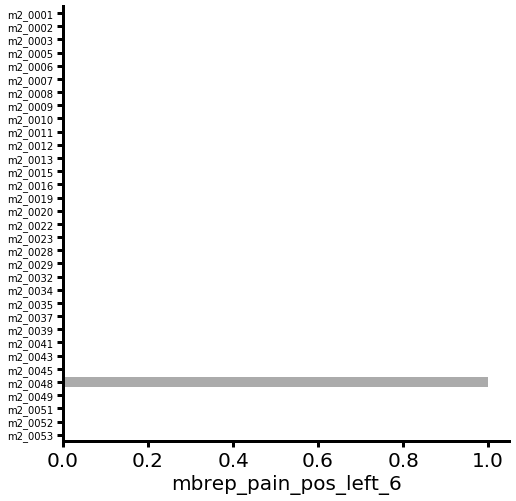

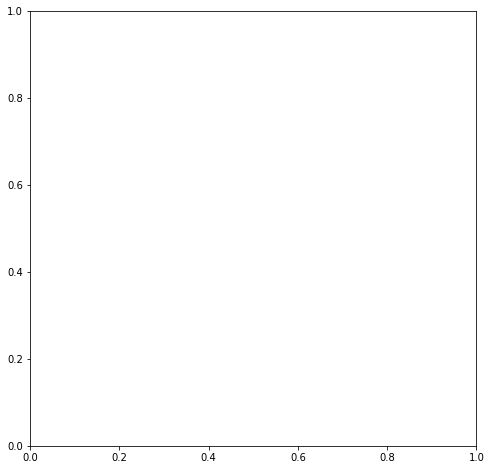

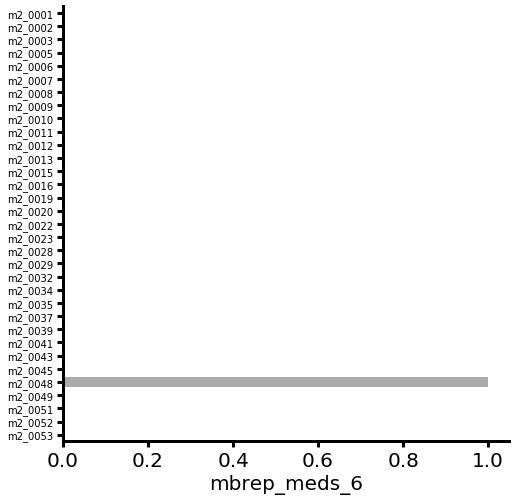

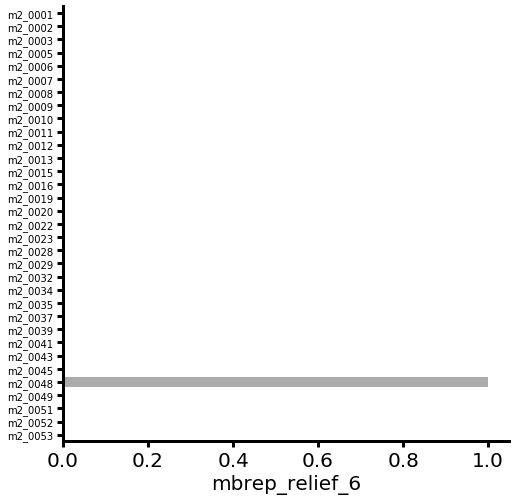

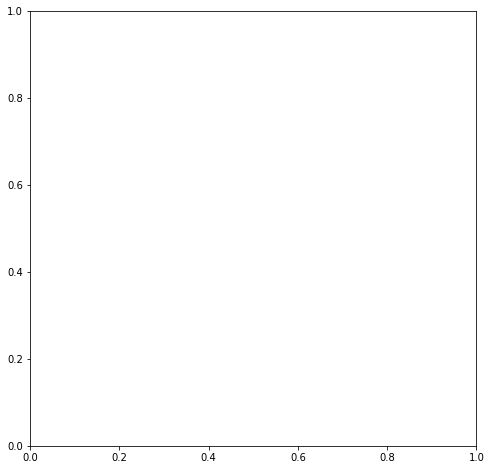

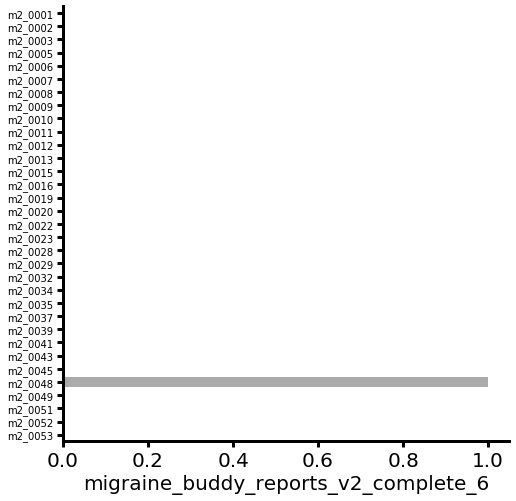

In [10]:
importlib.reload(fmt)
palette= load_palette()
subject_order = long_data.sort_values(by='subject_id').subject_id.unique()
plt.rcParams.update({'figure.max_open_warning': 0})
for col in pb.progressbar(long_data.columns):
    if col == 'subject_id':
        continue
    elif col in demog_cols:
        continue
    else:
        _, ax = plt.subplots(figsize=(8,8))

        counts = pd.DataFrame(
            long_data[['subject_id', col]].dropna().groupby('subject_id').count()
        ).reset_index()
        
        if counts.empty:
            continue

        if col in palette.keys():
            color = palette[col]
            c_palette = None
        else:
            color = None
            c_palette = 'Greys_d'
        sns.barplot(
            y='subject_id',
            x=col,
            data=counts,
            order=subject_order,
            palette=c_palette,
            color=color,
            ax=ax
        )
        fmt.despine_thicken_axes(
            ax=ax,
            lw=3,
            fontsize=20,
            rotate_x=0,
            y_tick_fontsize=10,
        )
        ax.set_ylabel('')
plt.rcParams.update({'figure.max_open_warning': 20})    

100% (7 of 7) |##########################| Elapsed Time: 0:00:02 Time:  0:00:02


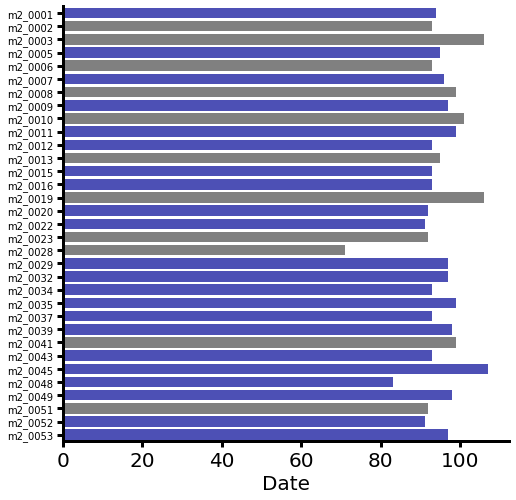

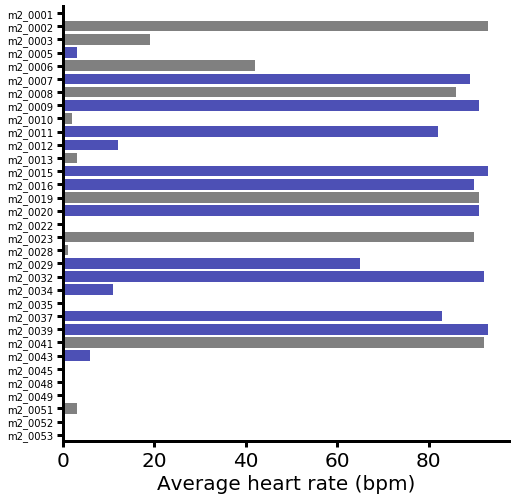

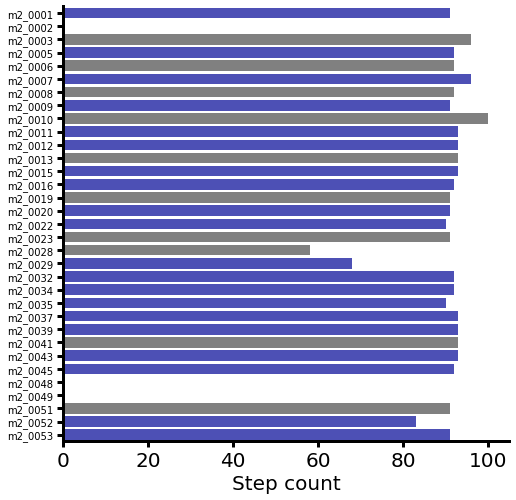

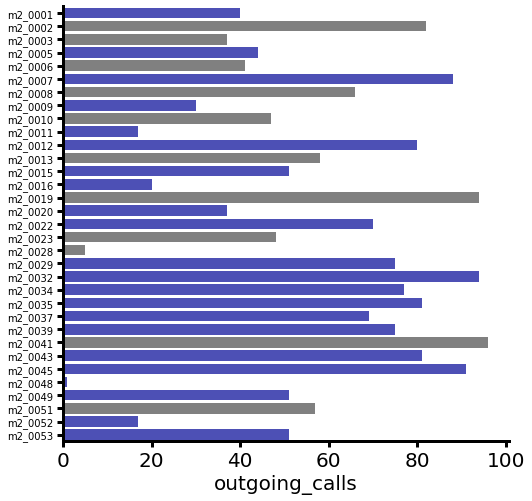

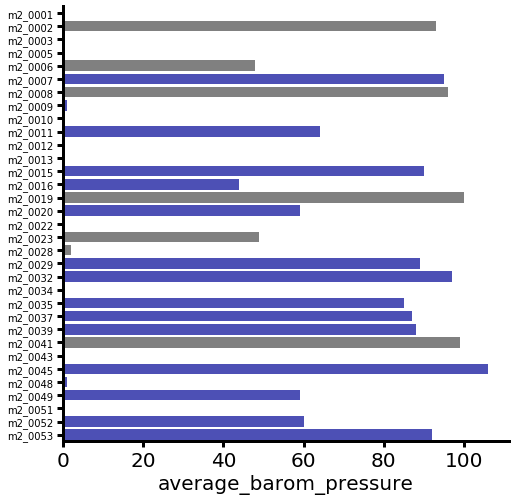

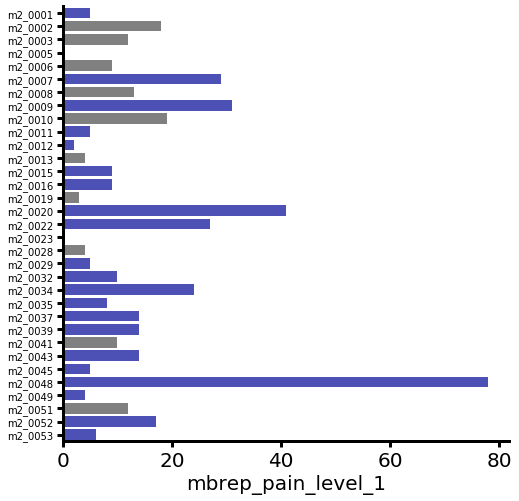

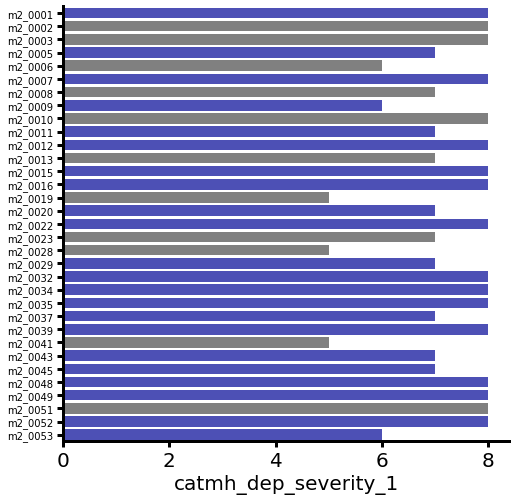

In [20]:
palette= load_palette()
subject_order = long_data.sort_values(by='subject_id').subject_id.unique()
plt.rcParams.update({'figure.max_open_warning': 0})

cols_of_interest = [
    'Date',
    'Average heart rate (bpm)',
    'Step count',
    'outgoing_calls',
    'average_barom_pressure',
    'mbrep_pain_level_1',
    'catmh_dep_severity_1',
]

for col in pb.progressbar(cols_of_interest):
    _, ax = plt.subplots(figsize=(8,8))

    counts = pd.DataFrame(
        long_data[['subject_id', 'catmh_mdd_diagnosis', col]].dropna().groupby(['subject_id', 'catmh_mdd_diagnosis']).count()
    ).reset_index()

    if counts.empty:
        continue

    hue_col = 'catmh_mdd_diagnosis'

    sns.barplot(
        y='subject_id',
        x=col,
        data=counts,
        hue=hue_col,
        palette=palette['catmh_mdd_diagnosis'],
        order=subject_order,
        ax=ax,
        dodge=False,
    )
    fmt.despine_thicken_axes(
        ax=ax,
        lw=3,
        fontsize=20,
        rotate_x=0,
        y_tick_fontsize=10,
    )
    ax.legend().remove()
    ax.set_ylabel('')
plt.rcParams.update({'figure.max_open_warning': 20}) 

In [58]:
import re
sort = long_data.sort_values(by=['catmh_mdd_diagnosis', 'subject_id'])
desc_data = sort[['subject_id', 'catmh_mdd_diagnosis']].drop_duplicates()
already_agg_cols = []

for col in sort.columns[1:]:
    if col in demog_cols:
        continue
    if re.match(r'\w+_\d+$' , col):
        base_col = '_'.join(col.split('_')[:-1])
        if base_col in already_agg_cols:
            continue
        else:
            already_agg_cols.append(base_col)
            cols = [c for c in sort.columns if re.match(base_col + r'_\d+$' ,c)]
            d_df = sort[['subject_id', 'Date'] + cols]
            if base_col == 'catmh_mdd_diagnosis':
                print(d_df.dropna(subset=['catmh_mdd_diagnosis_1']))
            d_df = d_df.melt(
                id_vars=['Date', 'subject_id'],
                value_vars=cols,
                var_name='n_logs',
                value_name=base_col
            )
            d_df = d_df[['subject_id', base_col]].dropna()
            col = base_col
            
    else:
        d_df = sort[['subject_id', col]].dropna()
    data_avail = pd.DataFrame(
        d_df.groupby('subject_id')[col].count()
    ).reset_index()
    desc_data = desc_data.merge(
        data_avail,
        how='left',
        validate='1:1'
    ).fillna(0)

    

     subject_id       Date  catmh_mdd_diagnosis_1  catmh_mdd_diagnosis_2
1499    m2_0002 2017-08-30                    0.0                    NaN
1513    m2_0002 2017-09-13                    0.0                    NaN
1527    m2_0002 2017-09-27                    0.0                    NaN
1541    m2_0002 2017-10-11                    0.0                    NaN
1555    m2_0002 2017-10-25                    0.0                    NaN
...         ...        ...                    ...                    ...
581     m2_0053 2019-01-11                    1.0                    NaN
593     m2_0053 2019-01-23                    1.0                    NaN
607     m2_0053 2019-02-06                    1.0                    NaN
621     m2_0053 2019-02-20                    1.0                    NaN
647     m2_0053 2019-03-18                    1.0                    NaN

[241 rows x 4 columns]


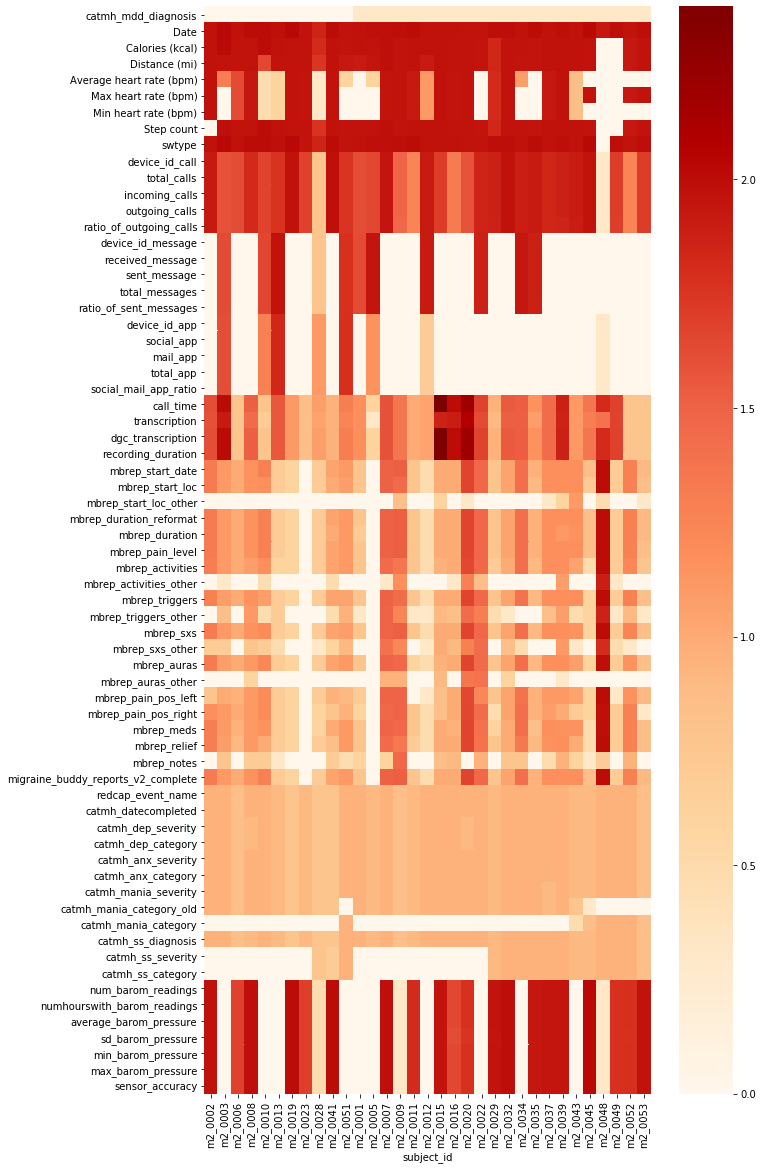

In [48]:
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(np.log10(1+desc_data.set_index('subject_id').T), cmap='OrRd', ax=ax)

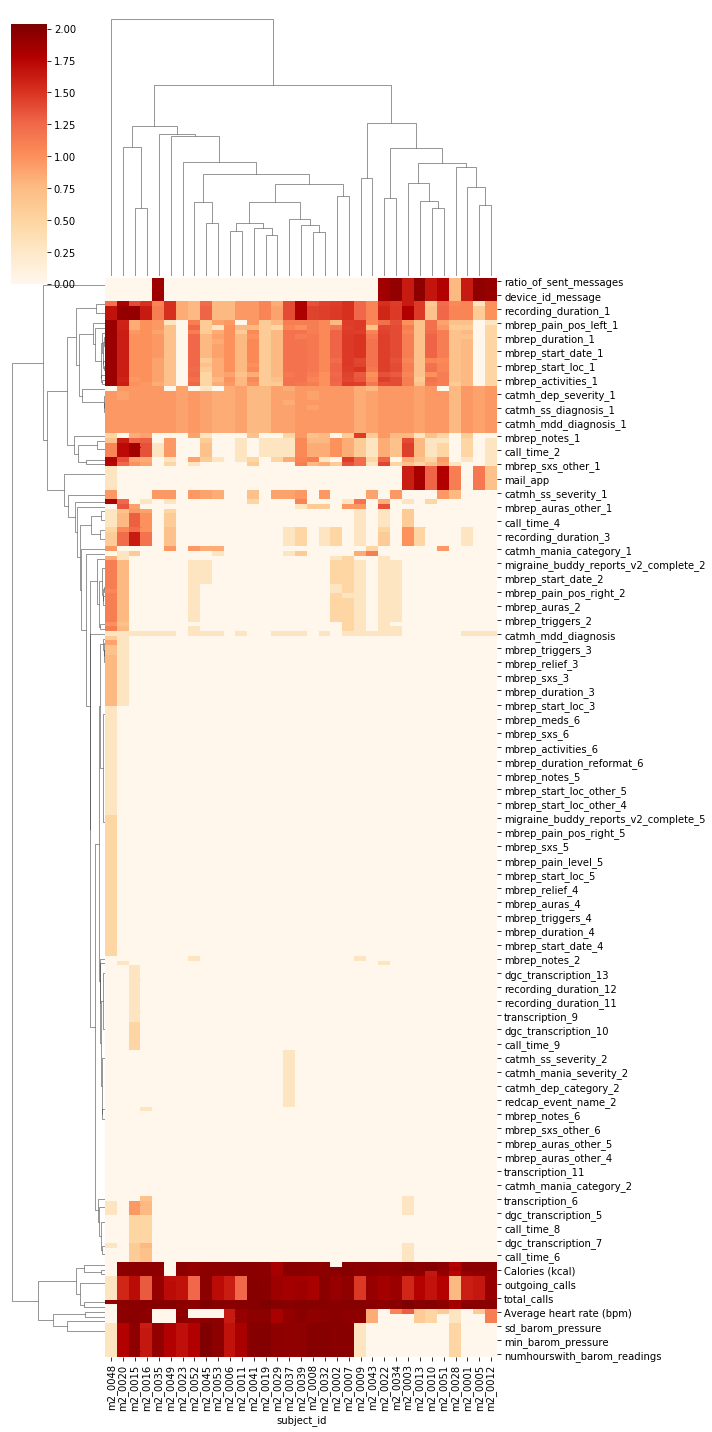

In [34]:
import numpy as np
sns.clustermap(np.log10(1+desc_data.set_index('subject_id').T), cmap='OrRd', figsize=(10,20))